# Flair NER Tagging Pipeline

## Navigation:
* [General Info](#info)

##### POS-tagging
* [Preparing Dataset for POS-tagger Training](#pos-prepare)
* [Create idx2char & char2idx for Character Embeddings](#pos-char-idx)
* [Training POS with Flair](#pos-train)
* [Hyperparameter Optimization with Flair and HyperOpt](#pos-hyperopt)
* [Prediction and Saving Results to CONLL-U](#pos-save)


##### NER
* [Preparing Dataset for NER](#ner-prepare)
* [Adding BIOES Annotation](#ner-bioes)
* [Training NER with Flair](#ner-train)
* [Using Trained Model for Prediction](#ner-predict)
* [Prediction and Saving to CONLL-U](#ner-save)

## General Info <a class="anchor" id="info"></a>

`Libraries needed:` `corpuscula.conllu` (conllu parsing); `flair` (training); `tqdm` (displaying progress)

`Pre-Trained Embeddings used in this example:` [DeepPavlov Wiki+Lenta](http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize.bin). Preprocessing included: `nltk wordpunсt_tokenize`

`Pipeline Input:` CONLL-U parsed text file.

`Processing:` Extracting tokens and named entities as separate lists of lists of strings, and adding BIOES tags to entities.

`Train Input:` `{train,dev,test}.txt` files in BIOES format as shown [here](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging))

`Sample train input:`
```
здравствуйте O
расскажите O
справочной S-Department
аэропорта S-Organization
город B-Geo
томск E-Geo
```

`Sample inference (predict) result:`
```
4 <B-Organization> больница <I-Organization> детская <I-Organization> городская <I-Organization> больница <I-Organization> номер <I-Organization> 4 <E-Organization> города <B-Geo> сочи <E-Geo> приемный <B-Department> покой <E-Department>
```

`Pipeline Output:` JSON with NER Parsing (list of lists of dict)

`Sample pipeline output:`
```
[[{'word': 'здравствуйте', 'entity': None},
  {'word': 'будьте', 'entity': None},
  {'word': 'добры', 'entity': None},
  {'word': 'подскажите', 'entity': None},
  {'word': 'мне', 'entity': None},
  {'word': 'регистратуру', 'entity': 'Department'},
  {'word': 'кожно', 'entity': 'Organization'},
  {'word': 'венерического', 'entity': 'Organization'},
  {'word': 'диспансера', 'entity': 'Organization'}],
  <...>]
```

Downloading Russian BPE embeddings. 100k(or 200k)-word vocab, 300d vectors

In [1]:
#!wget https://nlp.h-its.org/bpemb/ru/ru.wiki.bpe.vs200000.d300.w2v.bin.tar.gz

In [2]:
#!wget http://vectors.nlpl.eu/repository/20/182.zip

In [3]:
#!unzip 182.zip    # word2vec

In [4]:
#!tar --extract --file ru.wiki.bpe.vs200000.d300.w2v.bin.tar.gz    #bpe, unarchived to ./data/ru/ 

Downloading ruBERT from DeepPavlov

In [5]:
# !wget http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz

In [6]:
# !tar -zxvf rubert_cased_L-12_H-768_A-12_pt.tar.gz

`bert_config.json` has to be changed to `config.json`

In [7]:
# !cd rubert_cased_L-12_H-768_A-12_pt && mv bert_config.json config.json

In [8]:
from corpuscula.conllu import Conllu

import flair, torch
device = 'cuda:1'
flair.device = torch.device(device)
from flair.data import Corpus
from flair.datasets import ColumnCorpus
# need to figure out if these can be used with custom embeddings. Use FastTest for now.
from flair.embeddings import CharacterEmbeddings, \
                             TokenEmbeddings, \
                             WordEmbeddings, \
                             StackedEmbeddings, \
                             BytePairEmbeddings,\
                             FastTextEmbeddings,\
                             BertEmbeddings

from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from torch.optim.adam import Adam
import torch
import sys
from typing import List
from collections import OrderedDict
from tqdm import tqdm

## Preparing Dataset for POS-tagger Training  <a class="anchor" id="pos-prepare"></a>

In [9]:
def read_pos_corpus(corpus=None, silent=False):
    if isinstance(corpus, str):
        corpus = Conllu.load(corpus, **({'log_file': None} if silent else{}))
    elif callable(corpus):
        corpus = corpus()

    parsed_corpus = []
    parsed_pos = []
    
    for sent in corpus:
        curr_sent = [x['FORM'] for x in sent[0] if x['FORM'] and '-' not in x['ID']]
        curr_pos = [x['UPOS'] for x in sent[0] if x['UPOS'] and '-' not in x['ID']]
        parsed_corpus.append(curr_sent)
        parsed_pos.append(curr_pos)
    
    return parsed_corpus, parsed_pos

In [10]:
path = './corpuscula/corpus/syntagrus/'
syntagrus_train, pos_train = read_pos_corpus(path + 'ru_syntagrus-ud-train.conllu')
syntagrus_dev, pos_dev = read_pos_corpus(path + 'ru_syntagrus-ud-dev.conllu')
syntagrus_test, pos_test = read_pos_corpus(path + 'ru_syntagrus-ud-test.conllu')

Load corpus
[=================================================] 48814           
Corpus has been loaded: 48814 sentences, 871526 tokens
Load corpus
[=======] 6584                                                     
Corpus has been loaded: 6584 sentences, 118692 tokens
Load corpus
[=======] 6491                                                     
Corpus has been loaded: 6491 sentences, 117523 tokens


In [11]:
# Modify paths and file names, if necessary
import os

dn = './pos_corpus/'
if not os.path.isdir(dn):
    os.mkdir(dn)

with open(os.path.join(dn, 'train.txt'), 'wt', encoding='utf-8') as f:
    for i in range(len(syntagrus_train)):
        [print('\n'.join([' '.join(pair) for pair in list(zip(syntagrus_train[i],
                                                              pos_train[i]))]),
               file=f)]
        print(file=f)

with open(os.path.join(dn, 'dev.txt'), 'wt', encoding='utf-8') as f:
    for i in range(len(syntagrus_dev)):
        [print('\n'.join([' '.join(pair) for pair in list(zip(syntagrus_dev[i],
                                                              pos_dev[i]))]),
               file=f)]
        print(file=f)
        
with open(os.path.join(dn, 'test.txt'), 'wt', encoding='utf-8') as f:
    for i in range(len(syntagrus_test)):
        [print('\n'.join([' '.join(pair) for pair in list(zip(syntagrus_test[i],
                                                              pos_test[i]))]),
               file=f)]
        print(file=f)

## Create idx2char & char2idx for Character Embeddings <a class="anchor" id="pos-char-idx"></a>

In [12]:
# make an empty character dictionary
from flair.data import Dictionary
char_dictionary: Dictionary = Dictionary()

# counter object
import collections
counter = collections.Counter()

processed = 0

import glob
files = glob.glob('./pos_corpus/*.*')

print('files: ', files)
for file in files:
    print('file: ', file)

    with open(file, 'r', encoding='utf-8') as f:
        tokens = 0
        for line in f:

            processed += 1            
            chars = list(line)
            tokens += len(chars)

            # Add chars to the dictionary
            counter.update(chars)

            # comment this line in to speed things up (if the corpus is too large)
            # if tokens > 50000000: break

    # break

total_count = 0
for letter, count in counter.most_common():
    total_count += count

print('total_count ', total_count)
print('processed ', processed)

sum = 0
idx = 0
for letter, count in counter.most_common():
    sum += count
    percentile = (sum / total_count)

    # comment this line in to use only top X percentile of chars, otherwise filter later
    # if percentile < 0.00001: break

    char_dictionary.add_item(letter)
    idx += 1
    print('%d\t%s\t%7d\t%7d\t%f' % (idx, letter, count, sum, percentile))

print({k.decode('utf-8'): v for k,v in char_dictionary.item2idx.items()})

import pickle

path_to_char_dict='./resources/flair_char_mappers/flair_char_mapper.pkl'  # variable used later in loading character embeddings

with open(path_to_char_dict, 'wb') as f:
    mappings = {
        'idx2item': [i.decode('utf-8') for i in char_dictionary.idx2item],
        'item2idx': {k.decode('utf-8'): v for k,v in char_dictionary.item2idx.items()}
    }
    pickle.dump(mappings, f)

files:  ['./pos_corpus/train.txt', './pos_corpus/dev.txt', './pos_corpus/test.txt']
file:  ./pos_corpus/train.txt
file:  ./pos_corpus/dev.txt
file:  ./pos_corpus/test.txt
total_count  12318235
processed  1168185
1	
	1168185	1168185	0.094834
2	 	1106323	2274508	0.184646
3	N	 913004	3187512	0.258764
4	о	 585762	3773274	0.306316
5	U	 501181	4274455	0.347002
6	P	 472447	4746902	0.385356
7	е	 456684	5203586	0.422430
8	O	 421390	5624976	0.456638
9	и	 415138	6040114	0.490339
10	а	 405119	6445233	0.523227
11	н	 356991	6802224	0.552208
12	т	 344264	7146488	0.580155
13	A	 311812	7458300	0.605468
14	C	 300849	7759149	0.629891
15	D	 295952	8055101	0.653917
16	с	 290532	8345633	0.677502
17	T	 264004	8609637	0.698934
18	р	 262640	8872277	0.720256
19	R	 248417	9120694	0.740422
20	в	 232351	9353045	0.759285
21	л	 217864	9570909	0.776971
22	V	 180048	9750957	0.791587
23	к	 173203	9924160	0.805648
24	J	 167451	10091611	0.819242
25	м	 165025	10256636	0.832638
26	д	 153494	10410130	0.845099
27	E	 151703	1

In [13]:
#[i.decode('utf-8') for i in char_dictionary.idx2item]

In [14]:
#[i.decode('utf-8') for i in char_dictionary.item2idx.keys()]

## Training POS Model with Flair <a class="anchor" id="pos-train"></a>

In [15]:
# 1. Loading our corpus
# define columns (it is possible to add more columns, example: pos)
columns = {0: 'text', 1: 'pos'}

# this is the folder in which train, test and dev files reside
data_folder = './pos_corpus/'

# init a corpus using column format, data folder and the names 
# of the train, dev and test files
print('Loading a corpus...')
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='train.txt',
                              test_file='test.txt',
                              dev_file='dev.txt')
print(corpus)
print()

# 2. what tag do we want to predict?
tag_type = 'pos'

# 3. make a tag dictionary from the corpus
print('Make a tag dictionary...')
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary)
print()

Loading a corpus...
2020-04-20 08:54:25,786 Reading data from pos_corpus
2020-04-20 08:54:25,787 Train: pos_corpus/train.txt
2020-04-20 08:54:25,787 Dev: pos_corpus/dev.txt
2020-04-20 08:54:25,788 Test: pos_corpus/test.txt
Corpus: 48814 train + 6584 dev + 6491 test sentences

Make a tag dictionary...
Dictionary with 26 tags: <unk>, O, NOUN, PUNCT, ADJ, PROPN, AUX, VERB, ADP, ADV, CCONJ, PART, PRON, DET, SCONJ, NUM, INTJ, X, SYM, 000, 844, 734, 280, 200, <START>, <STOP>



## Hyperparameter Optimization with Flair and HyperOpt <a class="anchor" id="pos-hyperopt"></a>

In [16]:
from hyperopt import hp
from flair.hyperparameter.param_selection import SearchSpace, Parameter

In [17]:
# print('Loading word_embeddings_cbow...')
# word_embeddings_cbow = WordEmbeddings('./word2vec_rnc_ruwiki/model.bin')

# print('Loading fasttext_embeddings...')   # takes ridiculous time to load, crashes the kernel
# fasttext_embeddings = FastTextEmbeddings('ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize.bin')

# print('Loading bert_embeddings...')
# bert_embeddings = BertEmbeddings(bert_model_or_path='./rubert_cased_L-12_H-768_A-12_pt')  

# print('Loading character_embeddings...')
# character_embeddings = CharacterEmbeddings(path_to_char_dict=path_to_char_dict,
#                                            char_embedding_dim=25,
#                                            hidden_size_char=25
#                                            )
# print('Loading bpe_embeddings...')                                            
# bpe_embeddings = BytePairEmbeddings('ru', dim=300, syllables=200000)

NB! Unclear instructions in tutorial, fixed [here](https://github.com/flairNLP/flair/issues/370)

In [18]:
# define your search space
search_space = SearchSpace()
print('Adding embeddings to search space... ', end=' ')
search_space.add(Parameter.EMBEDDINGS, hp.choice, options=[
    StackedEmbeddings([ WordEmbeddings('./word2vec_rnc_ruwiki/model.bin'), BytePairEmbeddings('ru', dim=300, syllables=200000) ])
])
print('Done.')
print('Adding other parameters to search space... ', end=' ')
search_space.add(Parameter.HIDDEN_SIZE, hp.choice, options=[128, 256])
search_space.add(Parameter.RNN_LAYERS, hp.choice, options=[1, 2])
search_space.add(Parameter.DROPOUT, hp.uniform, low=0.0, high=0.5)
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[0.01, 0.05, 0.1])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[32, 64])
print('Done.')

Adding embeddings to search space...  Done.
Adding other parameters to search space...  Done.


In [ ]:
from flair.hyperparameter.param_selection import SequenceTaggerParamSelector, OptimizationValue

# create the parameter selector
param_selector = SequenceTaggerParamSelector(
    corpus, 
    'pos', 
    'resources/results',
    max_epochs=50,
    optimization_value=OptimizationValue.DEV_SCORE
)

# start the optimization
param_selector.optimize(search_space, max_evals=50)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]2020-04-20 09:00:51,147 ----------------------------------------------------------------------------------------------------
2020-04-20 09:00:51,148 Evaluation run: 1
2020-04-20 09:00:51,148 Evaluating parameter combination:
2020-04-20 09:00:51,148 	dropout: 0.4878124935138818
2020-04-20 09:00:51,149 	embeddings: StackedEmbeddings [0-./word2vec_rnc_ruwiki/model.bin,1-bpe-ru-200000-300]
2020-04-20 09:00:51,149 	hidden_size: 256
2020-04-20 09:00:51,150 	learning_rate: 0.05
2020-04-20 09:00:51,150 	mini_batch_size: 64
2020-04-20 09:00:51,150 	rnn_layers: 2
2020-04-20 09:00:51,151 ----------------------------------------------------------------------------------------------------
2020-04-20 09:00:51,411 ----------------------------------------------------------------------------------------------------
2020-04-20 09:00:51,412 Training run: 1
2020-04-20 09:00:55,253 ------------------------------------------------------------------------

2020-04-20 09:17:29,478 ----------------------------------------------------------------------------------------------------
2020-04-20 09:17:48,911 epoch 5 - iter 76/763 - loss 8.10644154 - samples/sec: 250.37
2020-04-20 09:18:07,421 epoch 5 - iter 152/763 - loss 7.99603327 - samples/sec: 262.85
2020-04-20 09:18:26,303 epoch 5 - iter 228/763 - loss 7.91508005 - samples/sec: 257.66
2020-04-20 09:18:45,298 epoch 5 - iter 304/763 - loss 7.89556513 - samples/sec: 256.13
2020-04-20 09:19:03,637 epoch 5 - iter 380/763 - loss 7.87205289 - samples/sec: 265.29
2020-04-20 09:19:22,580 epoch 5 - iter 456/763 - loss 7.85211381 - samples/sec: 256.83
2020-04-20 09:19:41,340 epoch 5 - iter 532/763 - loss 7.80483873 - samples/sec: 259.34
2020-04-20 09:20:01,280 epoch 5 - iter 608/763 - loss 7.77935813 - samples/sec: 243.98
2020-04-20 09:20:20,364 epoch 5 - iter 684/763 - loss 7.75393678 - samples/sec: 254.94
2020-04-20 09:20:39,393 epoch 5 - iter 760/763 - loss 7.73981382 - samples/sec: 255.67
2020-0

2020-04-20 09:39:13,156 epoch 11 - iter 304/763 - loss 5.88691703 - samples/sec: 253.77
2020-04-20 09:39:32,041 epoch 11 - iter 380/763 - loss 5.87190490 - samples/sec: 257.61
2020-04-20 09:39:50,933 epoch 11 - iter 456/763 - loss 5.86215304 - samples/sec: 257.53
2020-04-20 09:40:12,006 epoch 11 - iter 532/763 - loss 5.87549136 - samples/sec: 230.86
2020-04-20 09:40:30,475 epoch 11 - iter 608/763 - loss 5.86958643 - samples/sec: 263.43
2020-04-20 09:40:49,645 epoch 11 - iter 684/763 - loss 5.86728500 - samples/sec: 253.79
2020-04-20 09:41:08,637 epoch 11 - iter 760/763 - loss 5.86796874 - samples/sec: 256.17
2020-04-20 09:41:09,249 ----------------------------------------------------------------------------------------------------
2020-04-20 09:41:09,249 EPOCH 11 done: loss 5.8678 - lr 0.0500
2020-04-20 09:41:22,896 DEV : loss 2.6352503299713135 - score 0.9505
2020-04-20 09:41:23,139 BAD EPOCHS (no improvement): 0
2020-04-20 09:41:23,140 ------------------------------------------------

2020-04-20 10:00:58,220 epoch 17 - iter 608/763 - loss 5.25360759 - samples/sec: 250.06
2020-04-20 10:01:16,889 epoch 17 - iter 684/763 - loss 5.25028534 - samples/sec: 260.60
2020-04-20 10:01:35,848 epoch 17 - iter 760/763 - loss 5.25429721 - samples/sec: 256.62
2020-04-20 10:01:36,438 ----------------------------------------------------------------------------------------------------
2020-04-20 10:01:36,439 EPOCH 17 done: loss 5.2537 - lr 0.0500
2020-04-20 10:01:50,102 DEV : loss 2.318948745727539 - score 0.9562
2020-04-20 10:01:50,345 BAD EPOCHS (no improvement): 0
2020-04-20 10:01:50,346 ----------------------------------------------------------------------------------------------------
2020-04-20 10:02:09,237 epoch 18 - iter 76/763 - loss 5.13836311 - samples/sec: 257.55
2020-04-20 10:02:27,695 epoch 18 - iter 152/763 - loss 5.16524613 - samples/sec: 263.58
2020-04-20 10:02:46,490 epoch 18 - iter 228/763 - loss 5.15945394 - samples/sec: 258.85
2020-04-20 10:03:05,524 epoch 18 - it

2020-04-20 10:22:04,478 EPOCH 23 done: loss 4.9165 - lr 0.0500
2020-04-20 10:22:18,181 DEV : loss 2.1610500812530518 - score 0.9596
2020-04-20 10:22:18,422 BAD EPOCHS (no improvement): 0
2020-04-20 10:22:18,423 ----------------------------------------------------------------------------------------------------
2020-04-20 10:22:37,422 epoch 24 - iter 76/763 - loss 4.95182328 - samples/sec: 256.09
2020-04-20 10:22:56,234 epoch 24 - iter 152/763 - loss 4.88823753 - samples/sec: 258.62
2020-04-20 10:23:15,298 epoch 24 - iter 228/763 - loss 4.93154147 - samples/sec: 255.20
2020-04-20 10:23:34,355 epoch 24 - iter 304/763 - loss 4.91899971 - samples/sec: 255.29
2020-04-20 10:23:52,783 epoch 24 - iter 380/763 - loss 4.89463306 - samples/sec: 264.01
2020-04-20 10:24:11,996 epoch 24 - iter 456/763 - loss 4.87534554 - samples/sec: 253.23
2020-04-20 10:24:30,788 epoch 24 - iter 532/763 - loss 4.87557943 - samples/sec: 258.90
2020-04-20 10:24:49,549 epoch 24 - iter 608/763 - loss 4.86772154 - sampl

2020-04-20 10:43:05,491 epoch 30 - iter 76/763 - loss 4.68284859 - samples/sec: 255.91
2020-04-20 10:43:24,646 epoch 30 - iter 152/763 - loss 4.72424790 - samples/sec: 253.99
2020-04-20 10:43:43,450 epoch 30 - iter 228/763 - loss 4.68711718 - samples/sec: 258.74
2020-04-20 10:44:02,414 epoch 30 - iter 304/763 - loss 4.69087096 - samples/sec: 256.55
2020-04-20 10:44:21,156 epoch 30 - iter 380/763 - loss 4.67299415 - samples/sec: 259.59
2020-04-20 10:44:39,964 epoch 30 - iter 456/763 - loss 4.67334308 - samples/sec: 258.68
2020-04-20 10:44:58,954 epoch 30 - iter 532/763 - loss 4.67321513 - samples/sec: 256.19
2020-04-20 10:45:18,481 epoch 30 - iter 608/763 - loss 4.67819601 - samples/sec: 249.15
2020-04-20 10:45:37,285 epoch 30 - iter 684/763 - loss 4.68012383 - samples/sec: 258.73
2020-04-20 10:45:55,963 epoch 30 - iter 760/763 - loss 4.67363266 - samples/sec: 260.48
2020-04-20 10:45:56,699 -------------------------------------------------------------------------------------------------

2020-04-20 11:04:53,308 epoch 36 - iter 380/763 - loss 4.50219999 - samples/sec: 263.96
2020-04-20 11:05:12,415 epoch 36 - iter 456/763 - loss 4.51170314 - samples/sec: 254.64
2020-04-20 11:05:32,055 epoch 36 - iter 532/763 - loss 4.52731557 - samples/sec: 247.72
2020-04-20 11:05:51,090 epoch 36 - iter 608/763 - loss 4.51964888 - samples/sec: 255.59
2020-04-20 11:06:10,038 epoch 36 - iter 684/763 - loss 4.52108300 - samples/sec: 256.76
2020-04-20 11:06:28,840 epoch 36 - iter 760/763 - loss 4.51628793 - samples/sec: 258.76
2020-04-20 11:06:29,458 ----------------------------------------------------------------------------------------------------
2020-04-20 11:06:29,458 EPOCH 36 done: loss 4.5162 - lr 0.0500
2020-04-20 11:06:43,201 DEV : loss 1.9648351669311523 - score 0.963
2020-04-20 11:06:43,446 BAD EPOCHS (no improvement): 0
2020-04-20 11:06:43,446 ----------------------------------------------------------------------------------------------------
2020-04-20 11:07:03,967 epoch 37 - i

2020-04-20 11:26:39,840 epoch 42 - iter 684/763 - loss 4.40665260 - samples/sec: 255.87
2020-04-20 11:26:58,525 epoch 42 - iter 760/763 - loss 4.40347287 - samples/sec: 260.38
2020-04-20 11:26:59,157 ----------------------------------------------------------------------------------------------------
2020-04-20 11:26:59,158 EPOCH 42 done: loss 4.4012 - lr 0.0500
2020-04-20 11:27:12,992 DEV : loss 1.9432374238967896 - score 0.9639
2020-04-20 11:27:13,235 BAD EPOCHS (no improvement): 2
2020-04-20 11:27:13,236 ----------------------------------------------------------------------------------------------------
2020-04-20 11:27:32,406 epoch 43 - iter 76/763 - loss 4.34376305 - samples/sec: 253.80
2020-04-20 11:27:51,736 epoch 43 - iter 152/763 - loss 4.34851795 - samples/sec: 251.69
2020-04-20 11:28:10,591 epoch 43 - iter 228/763 - loss 4.35542374 - samples/sec: 258.03
2020-04-20 11:28:29,635 epoch 43 - iter 304/763 - loss 4.37495675 - samples/sec: 255.48
2020-04-20 11:28:48,104 epoch 43 - i

2020-04-20 11:47:27,288 EPOCH 48 done: loss 4.3035 - lr 0.0500
2020-04-20 11:47:41,034 DEV : loss 1.8641724586486816 - score 0.965
2020-04-20 11:47:41,276 BAD EPOCHS (no improvement): 2
2020-04-20 11:47:41,277 ----------------------------------------------------------------------------------------------------
2020-04-20 11:48:00,628 epoch 49 - iter 76/763 - loss 4.30067446 - samples/sec: 251.44
2020-04-20 11:48:19,541 epoch 49 - iter 152/763 - loss 4.31516651 - samples/sec: 257.24
2020-04-20 11:48:38,595 epoch 49 - iter 228/763 - loss 4.30528048 - samples/sec: 255.33
2020-04-20 11:48:57,462 epoch 49 - iter 304/763 - loss 4.31684467 - samples/sec: 257.87
2020-04-20 11:49:16,558 epoch 49 - iter 380/763 - loss 4.31682726 - samples/sec: 254.77
2020-04-20 11:49:35,288 epoch 49 - iter 456/763 - loss 4.30724141 - samples/sec: 259.76
2020-04-20 11:49:54,501 epoch 49 - iter 532/763 - loss 4.31307232 - samples/sec: 253.21
2020-04-20 11:50:13,390 epoch 49 - iter 608/763 - loss 4.30971106 - sample

2020-04-20 11:54:50,869 ----------------------------------------------------------------------------------------------------
2020-04-20 11:54:50,871 Corpus: "Corpus: 48814 train + 6584 dev + 6491 test sentences"
2020-04-20 11:54:50,874 ----------------------------------------------------------------------------------------------------
2020-04-20 11:54:50,876 Parameters:
2020-04-20 11:54:50,879  - learning_rate: "0.1"
2020-04-20 11:54:50,881  - mini_batch_size: "64"
2020-04-20 11:54:50,883  - patience: "3"
2020-04-20 11:54:50,886  - anneal_factor: "0.5"
2020-04-20 11:54:50,888  - max_epochs: "50"
2020-04-20 11:54:50,890  - shuffle: "True"
2020-04-20 11:54:50,893  - train_with_dev: "False"
2020-04-20 11:54:50,895  - batch_growth_annealing: "False"
2020-04-20 11:54:50,898 ----------------------------------------------------------------------------------------------------
2020-04-20 11:54:50,900 Model training base path: "resources/results"
2020-04-20 11:54:50,902 -------------------------

2020-04-20 12:11:08,138 epoch 6 - iter 304/763 - loss 4.27383650 - samples/sec: 323.76
2020-04-20 12:11:24,517 epoch 6 - iter 380/763 - loss 4.25556288 - samples/sec: 297.07
2020-04-20 12:11:39,887 epoch 6 - iter 456/763 - loss 4.24087802 - samples/sec: 316.57
2020-04-20 12:11:54,794 epoch 6 - iter 532/763 - loss 4.24835896 - samples/sec: 326.40
2020-04-20 12:12:09,985 epoch 6 - iter 608/763 - loss 4.24242287 - samples/sec: 320.31
2020-04-20 12:12:24,764 epoch 6 - iter 684/763 - loss 4.23797803 - samples/sec: 329.24
2020-04-20 12:12:39,596 epoch 6 - iter 760/763 - loss 4.22207606 - samples/sec: 328.04
2020-04-20 12:12:40,316 ----------------------------------------------------------------------------------------------------
2020-04-20 12:12:40,318 EPOCH 6 done: loss 4.2230 - lr 0.1000
2020-04-20 12:12:53,009 DEV : loss 2.06425142288208 - score 0.9611
2020-04-20 12:12:53,261 BAD EPOCHS (no improvement): 0
2020-04-20 12:12:53,261 ----------------------------------------------------------

2020-04-20 12:28:30,955 epoch 12 - iter 608/763 - loss 3.64718382 - samples/sec: 336.53
2020-04-20 12:28:45,965 epoch 12 - iter 684/763 - loss 3.65589033 - samples/sec: 324.17
2020-04-20 12:29:01,152 epoch 12 - iter 760/763 - loss 3.65842763 - samples/sec: 320.38
2020-04-20 12:29:01,703 ----------------------------------------------------------------------------------------------------
2020-04-20 12:29:01,704 EPOCH 12 done: loss 3.6577 - lr 0.1000
2020-04-20 12:29:14,188 DEV : loss 1.7942895889282227 - score 0.9664
2020-04-20 12:29:14,440 BAD EPOCHS (no improvement): 0
2020-04-20 12:29:14,441 ----------------------------------------------------------------------------------------------------
2020-04-20 12:29:29,148 epoch 13 - iter 76/763 - loss 3.55313278 - samples/sec: 330.86
2020-04-20 12:29:44,298 epoch 13 - iter 152/763 - loss 3.56797698 - samples/sec: 321.16
2020-04-20 12:29:59,274 epoch 13 - iter 228/763 - loss 3.53976199 - samples/sec: 324.92
2020-04-20 12:30:14,169 epoch 13 - i

2020-04-20 12:45:20,151 EPOCH 18 done: loss 3.4064 - lr 0.1000
2020-04-20 12:45:32,650 DEV : loss 1.6558005809783936 - score 0.9693
2020-04-20 12:45:32,902 BAD EPOCHS (no improvement): 0
2020-04-20 12:45:32,903 ----------------------------------------------------------------------------------------------------
2020-04-20 12:45:47,821 epoch 19 - iter 76/763 - loss 3.36158048 - samples/sec: 326.18
2020-04-20 12:46:02,943 epoch 19 - iter 152/763 - loss 3.37681798 - samples/sec: 321.77
2020-04-20 12:46:17,933 epoch 19 - iter 228/763 - loss 3.42466609 - samples/sec: 324.58
2020-04-20 12:46:32,620 epoch 19 - iter 304/763 - loss 3.44421780 - samples/sec: 331.31
2020-04-20 12:46:47,682 epoch 19 - iter 380/763 - loss 3.43691124 - samples/sec: 323.04
2020-04-20 12:47:02,193 epoch 19 - iter 456/763 - loss 3.42698355 - samples/sec: 335.32
2020-04-20 12:47:16,844 epoch 19 - iter 532/763 - loss 3.40926444 - samples/sec: 332.11
2020-04-20 12:47:32,247 epoch 19 - iter 608/763 - loss 3.40573277 - sampl

2020-04-20 13:02:08,121 epoch 25 - iter 76/763 - loss 3.26666746 - samples/sec: 332.69
2020-04-20 13:02:23,427 epoch 25 - iter 152/763 - loss 3.28633951 - samples/sec: 317.91
2020-04-20 13:02:38,185 epoch 25 - iter 228/763 - loss 3.26048149 - samples/sec: 329.70
2020-04-20 13:02:53,211 epoch 25 - iter 304/763 - loss 3.26464374 - samples/sec: 323.82
2020-04-20 13:03:08,246 epoch 25 - iter 380/763 - loss 3.26285936 - samples/sec: 323.62
2020-04-20 13:03:23,034 epoch 25 - iter 456/763 - loss 3.25635187 - samples/sec: 329.07
2020-04-20 13:03:37,749 epoch 25 - iter 532/763 - loss 3.26195314 - samples/sec: 330.67
2020-04-20 13:03:52,816 epoch 25 - iter 608/763 - loss 3.26357525 - samples/sec: 322.95
2020-04-20 13:04:07,345 epoch 25 - iter 684/763 - loss 3.25212286 - samples/sec: 334.88
2020-04-20 13:04:22,692 epoch 25 - iter 760/763 - loss 3.25276464 - samples/sec: 317.05
2020-04-20 13:04:23,187 -------------------------------------------------------------------------------------------------

2020-04-20 13:19:27,184 epoch 31 - iter 380/763 - loss 3.18371805 - samples/sec: 331.38
2020-04-20 13:19:41,969 epoch 31 - iter 456/763 - loss 3.17266684 - samples/sec: 329.10
2020-04-20 13:19:56,879 epoch 31 - iter 532/763 - loss 3.17159599 - samples/sec: 326.35
2020-04-20 13:20:11,622 epoch 31 - iter 608/763 - loss 3.16659020 - samples/sec: 330.06
2020-04-20 13:20:26,231 epoch 31 - iter 684/763 - loss 3.16648002 - samples/sec: 333.07
2020-04-20 13:20:41,393 epoch 31 - iter 760/763 - loss 3.16602715 - samples/sec: 320.90
2020-04-20 13:20:41,913 ----------------------------------------------------------------------------------------------------
2020-04-20 13:20:41,914 EPOCH 31 done: loss 3.1659 - lr 0.1000
2020-04-20 13:20:54,446 DEV : loss 1.5529712438583374 - score 0.9713
2020-04-20 13:20:54,698 BAD EPOCHS (no improvement): 0
2020-04-20 13:20:54,698 ----------------------------------------------------------------------------------------------------
2020-04-20 13:21:09,725 epoch 32 - 

2020-04-20 13:36:15,960 epoch 37 - iter 532/763 - loss 3.04767293 - samples/sec: 321.46
2020-04-20 13:36:30,803 epoch 37 - iter 608/763 - loss 3.04532249 - samples/sec: 327.80
2020-04-20 13:36:45,791 epoch 37 - iter 684/763 - loss 3.04447919 - samples/sec: 324.65
2020-04-20 13:37:00,406 epoch 37 - iter 760/763 - loss 3.02930173 - samples/sec: 332.93
2020-04-20 13:37:01,024 ----------------------------------------------------------------------------------------------------
2020-04-20 13:37:01,026 EPOCH 37 done: loss 3.0299 - lr 0.0500
2020-04-20 13:37:13,639 DEV : loss 1.5193791389465332 - score 0.9717
2020-04-20 13:37:13,888 BAD EPOCHS (no improvement): 0
2020-04-20 13:37:13,889 ----------------------------------------------------------------------------------------------------
2020-04-20 13:37:28,788 epoch 38 - iter 76/763 - loss 3.01266749 - samples/sec: 326.61
2020-04-20 13:37:43,835 epoch 38 - iter 152/763 - loss 3.00437823 - samples/sec: 323.37
2020-04-20 13:37:59,027 epoch 38 - i

2020-04-20 13:53:20,449 ----------------------------------------------------------------------------------------------------
2020-04-20 13:53:20,451 EPOCH 43 done: loss 2.9042 - lr 0.0500
2020-04-20 13:53:32,977 DEV : loss 1.4857927560806274 - score 0.9727
2020-04-20 13:53:33,232 BAD EPOCHS (no improvement): 2
2020-04-20 13:53:33,233 ----------------------------------------------------------------------------------------------------
2020-04-20 13:53:48,050 epoch 44 - iter 76/763 - loss 2.83390339 - samples/sec: 328.42
2020-04-20 13:54:03,280 epoch 44 - iter 152/763 - loss 2.89634285 - samples/sec: 319.48
2020-04-20 13:54:17,865 epoch 44 - iter 228/763 - loss 2.88078835 - samples/sec: 333.61
2020-04-20 13:54:32,538 epoch 44 - iter 304/763 - loss 2.88816348 - samples/sec: 331.63
2020-04-20 13:54:47,176 epoch 44 - iter 380/763 - loss 2.88954717 - samples/sec: 332.41
2020-04-20 13:55:02,032 epoch 44 - iter 456/763 - loss 2.89959581 - samples/sec: 327.54
2020-04-20 13:55:16,688 epoch 44 - i

2020-04-20 14:09:41,315 EPOCH 49 done: loss 2.8231 - lr 0.0250
2020-04-20 14:09:54,050 DEV : loss 1.4626024961471558 - score 0.9731
2020-04-20 14:09:54,302 BAD EPOCHS (no improvement): 1
2020-04-20 14:09:54,303 ----------------------------------------------------------------------------------------------------
2020-04-20 14:10:09,869 epoch 50 - iter 76/763 - loss 2.81202980 - samples/sec: 312.61
2020-04-20 14:10:24,832 epoch 50 - iter 152/763 - loss 2.81249681 - samples/sec: 325.17
2020-04-20 14:10:39,547 epoch 50 - iter 228/763 - loss 2.81691567 - samples/sec: 330.66
2020-04-20 14:10:54,196 epoch 50 - iter 304/763 - loss 2.79529138 - samples/sec: 332.16
2020-04-20 14:11:09,522 epoch 50 - iter 380/763 - loss 2.80930031 - samples/sec: 317.47
2020-04-20 14:11:24,134 epoch 50 - iter 456/763 - loss 2.80967074 - samples/sec: 333.02
2020-04-20 14:11:39,223 epoch 50 - iter 532/763 - loss 2.81223344 - samples/sec: 322.46
2020-04-20 14:11:54,265 epoch 50 - iter 608/763 - loss 2.81308883 - sampl

2020-04-20 14:12:57,259 ----------------------------------------------------------------------------------------------------
2020-04-20 14:13:23,708 epoch 1 - iter 76/763 - loss 34.60433727 - samples/sec: 183.95
2020-04-20 14:13:51,015 epoch 1 - iter 152/763 - loss 27.72793101 - samples/sec: 178.15
2020-04-20 14:14:17,559 epoch 1 - iter 228/763 - loss 24.03573952 - samples/sec: 183.28
2020-04-20 14:14:43,309 epoch 1 - iter 304/763 - loss 21.64450522 - samples/sec: 188.93
2020-04-20 14:15:09,554 epoch 1 - iter 380/763 - loss 19.92116451 - samples/sec: 185.37
2020-04-20 14:15:35,647 epoch 1 - iter 456/763 - loss 18.58858223 - samples/sec: 186.45
2020-04-20 14:16:03,571 epoch 1 - iter 532/763 - loss 17.53523590 - samples/sec: 174.21
2020-04-20 14:16:29,976 epoch 1 - iter 608/763 - loss 16.65569203 - samples/sec: 184.24
2020-04-20 14:16:56,536 epoch 1 - iter 684/763 - loss 15.90638127 - samples/sec: 183.17
2020-04-20 14:17:22,574 epoch 1 - iter 760/763 - loss 15.27037444 - samples/sec: 186

2020-04-20 14:34:51,021 epoch 7 - iter 304/763 - loss 5.44094509 - samples/sec: 253.47
2020-04-20 14:35:08,261 epoch 7 - iter 380/763 - loss 5.41602111 - samples/sec: 282.21
2020-04-20 14:35:26,049 epoch 7 - iter 456/763 - loss 5.40393257 - samples/sec: 273.52
2020-04-20 14:35:43,253 epoch 7 - iter 532/763 - loss 5.39316830 - samples/sec: 282.79
2020-04-20 14:36:00,683 epoch 7 - iter 608/763 - loss 5.38516738 - samples/sec: 279.14
2020-04-20 14:36:18,196 epoch 7 - iter 684/763 - loss 5.37239285 - samples/sec: 277.81
2020-04-20 14:36:35,856 epoch 7 - iter 760/763 - loss 5.37012019 - samples/sec: 275.50
2020-04-20 14:36:36,516 ----------------------------------------------------------------------------------------------------
2020-04-20 14:36:36,516 EPOCH 7 done: loss 5.3712 - lr 0.1000
2020-04-20 14:36:50,024 DEV : loss 2.406219720840454 - score 0.9555
2020-04-20 14:36:50,276 BAD EPOCHS (no improvement): 0
2020-04-20 14:36:50,277 ---------------------------------------------------------

2020-04-20 14:55:02,414 epoch 13 - iter 608/763 - loss 4.88091008 - samples/sec: 275.74
2020-04-20 14:55:19,382 epoch 13 - iter 684/763 - loss 4.87462545 - samples/sec: 286.75
2020-04-20 14:55:36,568 epoch 13 - iter 760/763 - loss 4.86953662 - samples/sec: 283.10
2020-04-20 14:55:37,200 ----------------------------------------------------------------------------------------------------
2020-04-20 14:55:37,200 EPOCH 13 done: loss 4.8689 - lr 0.1000
2020-04-20 14:55:50,686 DEV : loss 2.1693928241729736 - score 0.9598
2020-04-20 14:55:50,938 BAD EPOCHS (no improvement): 0
2020-04-20 14:55:50,939 ----------------------------------------------------------------------------------------------------
2020-04-20 14:56:09,141 epoch 14 - iter 76/763 - loss 4.87268236 - samples/sec: 267.32
2020-04-20 14:56:26,511 epoch 14 - iter 152/763 - loss 4.88681439 - samples/sec: 280.09
2020-04-20 14:56:43,779 epoch 14 - iter 228/763 - loss 4.85783179 - samples/sec: 281.75
2020-04-20 14:57:01,167 epoch 14 - i

2020-04-20 15:14:41,723 EPOCH 19 done: loss 4.6645 - lr 0.1000
2020-04-20 15:14:55,170 DEV : loss 2.032541036605835 - score 0.9619
2020-04-20 15:14:55,423 BAD EPOCHS (no improvement): 0
2020-04-20 15:14:55,424 ----------------------------------------------------------------------------------------------------
2020-04-20 15:15:12,966 epoch 20 - iter 76/763 - loss 4.62982338 - samples/sec: 277.37
2020-04-20 15:15:30,537 epoch 20 - iter 152/763 - loss 4.61807741 - samples/sec: 276.90
2020-04-20 15:15:47,899 epoch 20 - iter 228/763 - loss 4.60048253 - samples/sec: 280.22
2020-04-20 15:16:05,518 epoch 20 - iter 304/763 - loss 4.59919752 - samples/sec: 276.14
2020-04-20 15:16:22,753 epoch 20 - iter 380/763 - loss 4.61870360 - samples/sec: 282.30
2020-04-20 15:16:40,438 epoch 20 - iter 456/763 - loss 4.64593403 - samples/sec: 275.10
2020-04-20 15:16:57,962 epoch 20 - iter 532/763 - loss 4.63694542 - samples/sec: 277.64
2020-04-20 15:17:15,906 epoch 20 - iter 608/763 - loss 4.62341207 - sample

2020-04-20 15:34:12,351 epoch 26 - iter 76/763 - loss 4.53351548 - samples/sec: 272.03
2020-04-20 15:34:30,082 epoch 26 - iter 152/763 - loss 4.51624909 - samples/sec: 274.41
2020-04-20 15:34:48,193 epoch 26 - iter 228/763 - loss 4.53741321 - samples/sec: 268.64
2020-04-20 15:35:05,827 epoch 26 - iter 304/763 - loss 4.52206164 - samples/sec: 275.90
2020-04-20 15:35:23,162 epoch 26 - iter 380/763 - loss 4.50776293 - samples/sec: 280.68
2020-04-20 15:35:41,083 epoch 26 - iter 456/763 - loss 4.51055425 - samples/sec: 271.48
2020-04-20 15:35:58,305 epoch 26 - iter 532/763 - loss 4.49740241 - samples/sec: 282.51
2020-04-20 15:36:15,729 epoch 26 - iter 608/763 - loss 4.50480401 - samples/sec: 279.23
2020-04-20 15:36:33,364 epoch 26 - iter 684/763 - loss 4.50644460 - samples/sec: 275.88
2020-04-20 15:36:50,769 epoch 26 - iter 760/763 - loss 4.51140303 - samples/sec: 279.54
2020-04-20 15:36:51,348 -------------------------------------------------------------------------------------------------

2020-04-20 15:54:24,388 epoch 32 - iter 380/763 - loss 4.42478625 - samples/sec: 279.30
2020-04-20 15:54:41,605 epoch 32 - iter 456/763 - loss 4.43390889 - samples/sec: 282.58
2020-04-20 15:54:59,134 epoch 32 - iter 532/763 - loss 4.43228937 - samples/sec: 277.55
2020-04-20 15:55:16,572 epoch 32 - iter 608/763 - loss 4.43768651 - samples/sec: 279.01
2020-04-20 15:55:33,957 epoch 32 - iter 684/763 - loss 4.43517785 - samples/sec: 279.86
2020-04-20 15:55:51,882 epoch 32 - iter 760/763 - loss 4.44103323 - samples/sec: 271.42
2020-04-20 15:55:52,547 ----------------------------------------------------------------------------------------------------
2020-04-20 15:55:52,548 EPOCH 32 done: loss 4.4393 - lr 0.1000
2020-04-20 15:56:06,052 DEV : loss 1.8995163440704346 - score 0.9644
2020-04-20 15:56:06,304 BAD EPOCHS (no improvement): 0
2020-04-20 15:56:06,304 ----------------------------------------------------------------------------------------------------
2020-04-20 15:56:26,210 epoch 33 - 

2020-04-20 16:14:37,038 epoch 38 - iter 684/763 - loss 4.39083122 - samples/sec: 277.08
2020-04-20 16:14:54,627 epoch 38 - iter 760/763 - loss 4.38364550 - samples/sec: 276.61
2020-04-20 16:14:55,283 ----------------------------------------------------------------------------------------------------
2020-04-20 16:14:55,284 EPOCH 38 done: loss 4.3846 - lr 0.1000
2020-04-20 16:15:08,785 DEV : loss 1.8775317668914795 - score 0.9648
Epoch    38: reducing learning rate of group 0 to 5.0000e-02.                             
  4%|▍         | 2/50 [7:14:17<130:33:15, 9791.57s/trial, best loss: 0.026699999999999984]2020-04-20 16:15:09,039 BAD EPOCHS (no improvement): 4
2020-04-20 16:15:09,040 ----------------------------------------------------------------------------------------------------
2020-04-20 16:15:27,340 epoch 39 - iter 76/763 - loss 4.32541112 - samples/sec: 265.88
2020-04-20 16:15:44,794 epoch 39 - iter 152/763 - loss 4.31099408 - samples/sec: 278.75
2020-04-20 16:16:02,414 epoch 3

2020-04-20 16:33:58,004 ----------------------------------------------------------------------------------------------------
2020-04-20 16:33:58,005 EPOCH 44 done: loss 4.1228 - lr 0.0500
2020-04-20 16:34:11,419 DEV : loss 1.812130093574524 - score 0.9661
2020-04-20 16:34:11,672 BAD EPOCHS (no improvement): 0
2020-04-20 16:34:11,673 ----------------------------------------------------------------------------------------------------
2020-04-20 16:34:29,365 epoch 45 - iter 76/763 - loss 4.14748502 - samples/sec: 275.03
2020-04-20 16:34:46,882 epoch 45 - iter 152/763 - loss 4.15449552 - samples/sec: 277.73
2020-04-20 16:35:04,567 epoch 45 - iter 228/763 - loss 4.11358725 - samples/sec: 275.12
2020-04-20 16:35:22,208 epoch 45 - iter 304/763 - loss 4.11174786 - samples/sec: 275.79
2020-04-20 16:35:40,084 epoch 45 - iter 380/763 - loss 4.12149875 - samples/sec: 272.18
2020-04-20 16:35:57,910 epoch 45 - iter 456/763 - loss 4.11642956 - samples/sec: 272.93
2020-04-20 16:36:15,330 epoch 45 - it

2020-04-20 16:53:14,498 ----------------------------------------------------------------------------------------------------
2020-04-20 16:53:14,498 Testing using best model ...
2020-04-20 16:53:31,589 0.9697	0.9697	0.9697
2020-04-20 16:53:31,589 
MICRO_AVG: acc 0.9411 - f1-score 0.9697
MACRO_AVG: acc 0.7082 - f1-score 0.74473
000        tp: 0 - fp: 0 - fn: 2 - tn: 0 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
200        tp: 0 - fp: 0 - fn: 1 - tn: 0 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
280        tp: 0 - fp: 0 - fn: 1 - tn: 0 - precision: 0.0000 - recall: 0.0000 - accuracy: 0.0000 - f1-score: 0.0000
ADJ        tp: 10540 - fp: 820 - fn: 449 - tn: 10540 - precision: 0.9278 - recall: 0.9591 - accuracy: 0.8925 - f1-score: 0.9432
ADP        tp: 11508 - fp: 27 - fn: 8 - tn: 11508 - precision: 0.9977 - recall: 0.9993 - accuracy: 0.9970 - f1-score: 0.9985
ADV        tp: 5545 - fp: 162 - fn: 302 - tn: 5545 - precision: 0.9716

2020-04-20 16:58:21,769 epoch 2 - iter 152/763 - loss 7.61971099 - samples/sec: 342.44
2020-04-20 16:58:36,012 epoch 2 - iter 228/763 - loss 7.60292115 - samples/sec: 341.62
2020-04-20 16:58:50,230 epoch 2 - iter 304/763 - loss 7.49629697 - samples/sec: 342.22
2020-04-20 16:59:04,479 epoch 2 - iter 380/763 - loss 7.43240873 - samples/sec: 341.49
2020-04-20 16:59:18,672 epoch 2 - iter 456/763 - loss 7.37262675 - samples/sec: 342.84
2020-04-20 16:59:33,126 epoch 2 - iter 532/763 - loss 7.29910234 - samples/sec: 336.63
2020-04-20 16:59:47,440 epoch 2 - iter 608/763 - loss 7.22725131 - samples/sec: 339.93
2020-04-20 17:00:02,163 epoch 2 - iter 684/763 - loss 7.17650553 - samples/sec: 330.48
2020-04-20 17:00:16,262 epoch 2 - iter 760/763 - loss 7.11633492 - samples/sec: 345.12
2020-04-20 17:00:16,773 ----------------------------------------------------------------------------------------------------
2020-04-20 17:00:16,775 EPOCH 2 done: loss 7.1134 - lr 0.1000
2020-04-20 17:00:29,082 DEV : 

2020-04-20 17:15:13,906 epoch 8 - iter 532/763 - loss 5.12569661 - samples/sec: 330.72
2020-04-20 17:15:28,096 epoch 8 - iter 608/763 - loss 5.12313514 - samples/sec: 342.91
2020-04-20 17:15:42,336 epoch 8 - iter 684/763 - loss 5.13172218 - samples/sec: 341.72
2020-04-20 17:15:58,505 epoch 8 - iter 760/763 - loss 5.14010875 - samples/sec: 300.92
2020-04-20 17:15:59,030 ----------------------------------------------------------------------------------------------------
2020-04-20 17:15:59,031 EPOCH 8 done: loss 5.1391 - lr 0.1000
2020-04-20 17:16:11,332 DEV : loss 2.337336540222168 - score 0.9554
2020-04-20 17:16:11,585 BAD EPOCHS (no improvement): 0
2020-04-20 17:16:11,586 ----------------------------------------------------------------------------------------------------
2020-04-20 17:16:26,048 epoch 9 - iter 76/763 - loss 4.98350955 - samples/sec: 336.49
2020-04-20 17:16:40,695 epoch 9 - iter 152/763 - loss 5.02502081 - samples/sec: 332.18
2020-04-20 17:16:54,927 epoch 9 - iter 228/7

2020-04-20 17:31:43,063 ----------------------------------------------------------------------------------------------------
2020-04-20 17:31:43,065 EPOCH 14 done: loss 4.7902 - lr 0.1000
2020-04-20 17:31:55,409 DEV : loss 2.163386344909668 - score 0.959
2020-04-20 17:31:55,661 BAD EPOCHS (no improvement): 0
2020-04-20 17:31:55,662 ----------------------------------------------------------------------------------------------------
2020-04-20 17:32:09,817 epoch 15 - iter 76/763 - loss 4.77204323 - samples/sec: 343.77
2020-04-20 17:32:23,884 epoch 15 - iter 152/763 - loss 4.69139325 - samples/sec: 345.88
2020-04-20 17:32:38,251 epoch 15 - iter 228/763 - loss 4.69060979 - samples/sec: 338.68
2020-04-20 17:32:52,235 epoch 15 - iter 304/763 - loss 4.71542285 - samples/sec: 347.97
2020-04-20 17:33:06,795 epoch 15 - iter 380/763 - loss 4.73907407 - samples/sec: 334.18
2020-04-20 17:33:21,057 epoch 15 - iter 456/763 - loss 4.73662915 - samples/sec: 341.17
2020-04-20 17:33:35,726 epoch 15 - ite

2020-04-20 17:47:40,146 ----------------------------------------------------------------------------------------------------
2020-04-20 17:47:54,742 epoch 21 - iter 76/763 - loss 4.58327305 - samples/sec: 333.38
2020-04-20 17:48:08,951 epoch 21 - iter 152/763 - loss 4.57854904 - samples/sec: 342.45
2020-04-20 17:48:23,355 epoch 21 - iter 228/763 - loss 4.57303990 - samples/sec: 337.82
2020-04-20 17:48:37,915 epoch 21 - iter 304/763 - loss 4.60761165 - samples/sec: 334.17
2020-04-20 17:48:52,397 epoch 21 - iter 380/763 - loss 4.61722547 - samples/sec: 336.01
2020-04-20 17:49:06,728 epoch 21 - iter 456/763 - loss 4.62140304 - samples/sec: 339.53
2020-04-20 17:49:20,674 epoch 21 - iter 532/763 - loss 4.61153681 - samples/sec: 348.90
2020-04-20 17:49:35,142 epoch 21 - iter 608/763 - loss 4.61327875 - samples/sec: 336.32
2020-04-20 17:49:49,551 epoch 21 - iter 684/763 - loss 4.61065365 - samples/sec: 337.68
2020-04-20 17:50:03,699 epoch 21 - iter 760/763 - loss 4.60968309 - samples/sec: 343

2020-04-20 18:04:07,618 epoch 27 - iter 228/763 - loss 4.53535715 - samples/sec: 342.43
2020-04-20 18:04:22,041 epoch 27 - iter 304/763 - loss 4.53339784 - samples/sec: 337.38
2020-04-20 18:04:36,771 epoch 27 - iter 380/763 - loss 4.53689344 - samples/sec: 330.34
2020-04-20 18:04:51,381 epoch 27 - iter 456/763 - loss 4.53904452 - samples/sec: 333.03
2020-04-20 18:05:05,535 epoch 27 - iter 532/763 - loss 4.53385502 - samples/sec: 343.80
2020-04-20 18:05:19,585 epoch 27 - iter 608/763 - loss 4.53406704 - samples/sec: 346.32
2020-04-20 18:05:33,594 epoch 27 - iter 684/763 - loss 4.53165666 - samples/sec: 347.35
2020-04-20 18:05:47,739 epoch 27 - iter 760/763 - loss 4.52646423 - samples/sec: 344.01
2020-04-20 18:05:48,264 ----------------------------------------------------------------------------------------------------
2020-04-20 18:05:48,265 EPOCH 27 done: loss 4.5267 - lr 0.1000
2020-04-20 18:06:00,683 DEV : loss 2.0086264610290527 - score 0.9618
2020-04-20 18:06:00,940 BAD EPOCHS (no 

2020-04-20 18:20:50,488 epoch 33 - iter 532/763 - loss 4.47512025 - samples/sec: 341.96
2020-04-20 18:21:04,761 epoch 33 - iter 608/763 - loss 4.47901739 - samples/sec: 340.90
2020-04-20 18:21:19,093 epoch 33 - iter 684/763 - loss 4.47863064 - samples/sec: 339.52
2020-04-20 18:21:33,014 epoch 33 - iter 760/763 - loss 4.46760778 - samples/sec: 349.53
2020-04-20 18:21:33,565 ----------------------------------------------------------------------------------------------------
2020-04-20 18:21:33,567 EPOCH 33 done: loss 4.4692 - lr 0.1000
2020-04-20 18:21:45,917 DEV : loss 1.9869390726089478 - score 0.9626
2020-04-20 18:21:46,172 BAD EPOCHS (no improvement): 0
2020-04-20 18:21:46,173 ----------------------------------------------------------------------------------------------------
2020-04-20 18:22:00,378 epoch 34 - iter 76/763 - loss 4.42255971 - samples/sec: 342.56
2020-04-20 18:22:14,778 epoch 34 - iter 152/763 - loss 4.47510421 - samples/sec: 337.91
2020-04-20 18:22:28,984 epoch 34 - i

2020-04-20 18:37:03,108 epoch 39 - iter 684/763 - loss 4.28238767 - samples/sec: 342.70
2020-04-20 18:37:19,130 epoch 39 - iter 760/763 - loss 4.28803085 - samples/sec: 303.69
2020-04-20 18:37:19,710 ----------------------------------------------------------------------------------------------------
2020-04-20 18:37:19,712 EPOCH 39 done: loss 4.2871 - lr 0.0500
2020-04-20 18:37:32,020 DEV : loss 1.927907109260559 - score 0.9633
2020-04-20 18:37:32,270 BAD EPOCHS (no improvement): 1
2020-04-20 18:37:32,271 ----------------------------------------------------------------------------------------------------
2020-04-20 18:37:46,522 epoch 40 - iter 76/763 - loss 4.29460370 - samples/sec: 341.48
2020-04-20 18:38:00,772 epoch 40 - iter 152/763 - loss 4.29151445 - samples/sec: 341.44
2020-04-20 18:38:14,931 epoch 40 - iter 228/763 - loss 4.27326616 - samples/sec: 343.66
2020-04-20 18:38:28,939 epoch 40 - iter 304/763 - loss 4.27392637 - samples/sec: 347.37
2020-04-20 18:38:43,114 epoch 40 - it

2020-04-20 18:53:02,173 EPOCH 45 done: loss 4.1899 - lr 0.0500
2020-04-20 18:53:14,465 DEV : loss 1.8729815483093262 - score 0.9647
2020-04-20 18:53:14,721 BAD EPOCHS (no improvement): 0
2020-04-20 18:53:14,722 ----------------------------------------------------------------------------------------------------
2020-04-20 18:53:29,202 epoch 46 - iter 76/763 - loss 4.17048457 - samples/sec: 336.06
2020-04-20 18:53:43,478 epoch 46 - iter 152/763 - loss 4.20192997 - samples/sec: 340.82
2020-04-20 18:53:57,828 epoch 46 - iter 228/763 - loss 4.16405435 - samples/sec: 339.09
2020-04-20 18:54:12,527 epoch 46 - iter 304/763 - loss 4.19066666 - samples/sec: 331.03
2020-04-20 18:54:26,600 epoch 46 - iter 380/763 - loss 4.18077680 - samples/sec: 345.75
2020-04-20 18:54:40,686 epoch 46 - iter 456/763 - loss 4.16257215 - samples/sec: 345.45
2020-04-20 18:54:54,869 epoch 46 - iter 532/763 - loss 4.15119795 - samples/sec: 343.07
2020-04-20 18:55:08,905 epoch 46 - iter 608/763 - loss 4.15078950 - sampl

2020-04-20 19:06:37,325 ----------------------------------------------------------------------------------------------------
2020-04-20 19:06:37,327 ----------------------------------------------------------------------------------------------------
2020-04-20 19:06:37,327 Done evaluating parameter combination:
2020-04-20 19:06:37,328 	dropout: 0.11237817875137501
2020-04-20 19:06:37,328 	embeddings: StackedEmbeddings [0-./word2vec_rnc_ruwiki/model.bin,1-bpe-ru-200000-300]
2020-04-20 19:06:37,328 	hidden_size: 128
2020-04-20 19:06:37,328 	learning_rate: 0.1
2020-04-20 19:06:37,329 	mini_batch_size: 64
2020-04-20 19:06:37,329 	rnn_layers: 1
2020-04-20 19:06:37,329 score: 0.03530000000000003
2020-04-20 19:06:37,330 variance: 1.8000000000000476e-07
2020-04-20 19:06:37,330 test_score: 0.9685

2020-04-20 19:06:37,330 ----------------------------------------------------------------------------------------------------
  8%|▊         | 4/50 [10:05:46<117:46:46, 9217.53s/trial, best loss: 0.026

2020-04-20 19:23:19,411 epoch 4 - iter 456/1526 - loss 13.31006795 - samples/sec: 189.68
2020-04-20 19:23:44,627 epoch 4 - iter 608/1526 - loss 13.25548262 - samples/sec: 192.94
2020-04-20 19:24:10,122 epoch 4 - iter 760/1526 - loss 13.22173247 - samples/sec: 190.82
2020-04-20 19:24:35,551 epoch 4 - iter 912/1526 - loss 13.12075715 - samples/sec: 191.32
2020-04-20 19:25:00,945 epoch 4 - iter 1064/1526 - loss 13.08331905 - samples/sec: 191.59
2020-04-20 19:25:27,344 epoch 4 - iter 1216/1526 - loss 13.05582389 - samples/sec: 184.29
2020-04-20 19:25:52,316 epoch 4 - iter 1368/1526 - loss 12.99745097 - samples/sec: 194.82
2020-04-20 19:26:17,956 epoch 4 - iter 1520/1526 - loss 12.94247336 - samples/sec: 189.75
2020-04-20 19:26:18,883 ----------------------------------------------------------------------------------------------------
2020-04-20 19:26:18,884 EPOCH 4 done: loss 12.9384 - lr 0.0100
2020-04-20 19:26:34,606 DEV : loss 8.632576942443848 - score 0.8271
2020-04-20 19:26:34,860 BAD 

2020-04-20 19:51:56,010 epoch 10 - iter 912/1526 - loss 9.15002444 - samples/sec: 189.83
2020-04-20 19:52:21,258 epoch 10 - iter 1064/1526 - loss 9.12275165 - samples/sec: 192.69
2020-04-20 19:52:46,748 epoch 10 - iter 1216/1526 - loss 9.10605724 - samples/sec: 190.86
2020-04-20 19:53:12,595 epoch 10 - iter 1368/1526 - loss 9.08606627 - samples/sec: 188.23
2020-04-20 19:53:38,772 epoch 10 - iter 1520/1526 - loss 9.07609421 - samples/sec: 185.85
2020-04-20 19:53:39,723 ----------------------------------------------------------------------------------------------------
2020-04-20 19:53:39,724 EPOCH 10 done: loss 9.0757 - lr 0.0100
2020-04-20 19:53:55,333 DEV : loss 5.136801719665527 - score 0.9026
2020-04-20 19:53:55,589 BAD EPOCHS (no improvement): 0
2020-04-20 19:53:55,589 ----------------------------------------------------------------------------------------------------
2020-04-20 19:54:20,721 epoch 11 - iter 152/1526 - loss 8.81277413 - samples/sec: 193.60
2020-04-20 19:54:46,019 ep

2020-04-20 20:20:29,207 epoch 16 - iter 1368/1526 - loss 7.42301824 - samples/sec: 193.41
2020-04-20 20:20:54,697 epoch 16 - iter 1520/1526 - loss 7.41554645 - samples/sec: 190.86
2020-04-20 20:20:55,600 ----------------------------------------------------------------------------------------------------
2020-04-20 20:20:55,600 EPOCH 16 done: loss 7.4137 - lr 0.0100
2020-04-20 20:21:11,243 DEV : loss 3.7612178325653076 - score 0.9298
2020-04-20 20:21:11,500 BAD EPOCHS (no improvement): 0
2020-04-20 20:21:11,500 ----------------------------------------------------------------------------------------------------
2020-04-20 20:21:36,957 epoch 17 - iter 152/1526 - loss 7.15644915 - samples/sec: 191.13
2020-04-20 20:22:02,018 epoch 17 - iter 304/1526 - loss 7.23055537 - samples/sec: 194.13
2020-04-20 20:22:27,902 epoch 17 - iter 456/1526 - loss 7.22554467 - samples/sec: 187.96
2020-04-20 20:22:53,266 epoch 17 - iter 608/1526 - loss 7.26022954 - samples/sec: 191.81
2020-04-20 20:23:18,426 epo

2020-04-20 20:48:14,954 EPOCH 22 done: loss 6.5641 - lr 0.0100
2020-04-20 20:48:30,840 DEV : loss 3.188699960708618 - score 0.9409
2020-04-20 20:48:31,097 BAD EPOCHS (no improvement): 0
2020-04-20 20:48:31,097 ----------------------------------------------------------------------------------------------------
2020-04-20 20:48:56,818 epoch 23 - iter 152/1526 - loss 6.43597490 - samples/sec: 189.16
2020-04-20 20:49:22,583 epoch 23 - iter 304/1526 - loss 6.48997291 - samples/sec: 188.83
2020-04-20 20:49:48,314 epoch 23 - iter 456/1526 - loss 6.50090729 - samples/sec: 189.08
2020-04-20 20:50:13,587 epoch 23 - iter 608/1526 - loss 6.48914968 - samples/sec: 192.50
2020-04-20 20:50:39,201 epoch 23 - iter 760/1526 - loss 6.50440183 - samples/sec: 189.94
2020-04-20 20:51:04,597 epoch 23 - iter 912/1526 - loss 6.48710017 - samples/sec: 191.58
2020-04-20 20:51:30,047 epoch 23 - iter 1064/1526 - loss 6.47413356 - samples/sec: 191.16
2020-04-20 20:51:55,472 epoch 23 - iter 1216/1526 - loss 6.454786

2020-04-20 21:16:14,945 epoch 29 - iter 152/1526 - loss 5.97361399 - samples/sec: 189.65
2020-04-20 21:16:40,912 epoch 29 - iter 304/1526 - loss 5.98865425 - samples/sec: 187.36
2020-04-20 21:17:06,956 epoch 29 - iter 456/1526 - loss 6.00538016 - samples/sec: 186.81
2020-04-20 21:17:31,847 epoch 29 - iter 608/1526 - loss 5.99742343 - samples/sec: 195.46
2020-04-20 21:17:57,437 epoch 29 - iter 760/1526 - loss 5.99714067 - samples/sec: 190.12
2020-04-20 21:18:23,255 epoch 29 - iter 912/1526 - loss 5.99205122 - samples/sec: 188.44
2020-04-20 21:18:48,369 epoch 29 - iter 1064/1526 - loss 5.97602537 - samples/sec: 193.72
2020-04-20 21:19:13,879 epoch 29 - iter 1216/1526 - loss 5.98783791 - samples/sec: 190.71
2020-04-20 21:19:39,357 epoch 29 - iter 1368/1526 - loss 5.98493108 - samples/sec: 190.95
2020-04-20 21:20:05,012 epoch 29 - iter 1520/1526 - loss 5.98102228 - samples/sec: 189.64
2020-04-20 21:20:06,012 ----------------------------------------------------------------------------------

2020-04-20 21:44:45,257 epoch 35 - iter 608/1526 - loss 5.58268096 - samples/sec: 192.23
2020-04-20 21:45:10,030 epoch 35 - iter 760/1526 - loss 5.56613438 - samples/sec: 196.39
2020-04-20 21:45:35,551 epoch 35 - iter 912/1526 - loss 5.59824994 - samples/sec: 190.63
2020-04-20 21:46:01,112 epoch 35 - iter 1064/1526 - loss 5.62161388 - samples/sec: 190.34
2020-04-20 21:46:26,427 epoch 35 - iter 1216/1526 - loss 5.62763437 - samples/sec: 192.18
2020-04-20 21:46:52,370 epoch 35 - iter 1368/1526 - loss 5.61992074 - samples/sec: 187.53
2020-04-20 21:47:19,189 epoch 35 - iter 1520/1526 - loss 5.61557844 - samples/sec: 181.40
2020-04-20 21:47:20,051 ----------------------------------------------------------------------------------------------------
2020-04-20 21:47:20,051 EPOCH 35 done: loss 5.6140 - lr 0.0100
2020-04-20 21:47:35,648 DEV : loss 2.6250691413879395 - score 0.9514
2020-04-20 21:47:35,903 BAD EPOCHS (no improvement): 1
2020-04-20 21:47:35,904 -------------------------------------

2020-04-20 22:13:17,921 epoch 41 - iter 1064/1526 - loss 5.37808557 - samples/sec: 189.99
2020-04-20 22:13:43,338 epoch 41 - iter 1216/1526 - loss 5.37279351 - samples/sec: 191.41
2020-04-20 22:14:08,984 epoch 41 - iter 1368/1526 - loss 5.36841123 - samples/sec: 189.70
2020-04-20 22:14:34,958 epoch 41 - iter 1520/1526 - loss 5.37481273 - samples/sec: 187.30
2020-04-20 22:14:35,782 ----------------------------------------------------------------------------------------------------
2020-04-20 22:14:35,783 EPOCH 41 done: loss 5.3725 - lr 0.0100
2020-04-20 22:14:51,543 DEV : loss 2.478133201599121 - score 0.9539
2020-04-20 22:14:51,800 BAD EPOCHS (no improvement): 1
2020-04-20 22:14:51,800 ----------------------------------------------------------------------------------------------------
2020-04-20 22:15:17,166 epoch 42 - iter 152/1526 - loss 5.35916191 - samples/sec: 191.81
2020-04-20 22:15:42,920 epoch 42 - iter 304/1526 - loss 5.36547349 - samples/sec: 188.90
2020-04-20 22:16:09,064 ep

2020-04-20 22:41:55,305 epoch 47 - iter 1520/1526 - loss 5.15651749 - samples/sec: 188.89
2020-04-20 22:41:56,236 ----------------------------------------------------------------------------------------------------
2020-04-20 22:41:56,237 EPOCH 47 done: loss 5.1570 - lr 0.0100
2020-04-20 22:42:12,124 DEV : loss 2.3177273273468018 - score 0.9571
2020-04-20 22:42:12,383 BAD EPOCHS (no improvement): 0
2020-04-20 22:42:12,383 ----------------------------------------------------------------------------------------------------
2020-04-20 22:42:37,747 epoch 48 - iter 152/1526 - loss 5.09585191 - samples/sec: 191.82
2020-04-20 22:43:03,051 epoch 48 - iter 304/1526 - loss 5.14382103 - samples/sec: 192.27
2020-04-20 22:43:28,584 epoch 48 - iter 456/1526 - loss 5.14257512 - samples/sec: 190.54
2020-04-20 22:43:54,094 epoch 48 - iter 608/1526 - loss 5.13376711 - samples/sec: 190.72
2020-04-20 22:44:20,427 epoch 48 - iter 760/1526 - loss 5.13650956 - samples/sec: 184.75
2020-04-20 22:44:46,317 epoc

2020-04-20 23:14:42,014 BAD EPOCHS (no improvement): 0
2020-04-20 23:14:42,014 ----------------------------------------------------------------------------------------------------
2020-04-20 23:15:05,457 epoch 5 - iter 152/1526 - loss 5.03495100 - samples/sec: 207.55
2020-04-20 23:15:29,310 epoch 5 - iter 304/1526 - loss 5.04831259 - samples/sec: 203.97
2020-04-20 23:15:52,971 epoch 5 - iter 456/1526 - loss 5.06912581 - samples/sec: 205.62
2020-04-20 23:16:16,410 epoch 5 - iter 608/1526 - loss 5.05984618 - samples/sec: 207.57
2020-04-20 23:16:39,987 epoch 5 - iter 760/1526 - loss 5.04116584 - samples/sec: 206.35
2020-04-20 23:17:03,680 epoch 5 - iter 912/1526 - loss 5.03213295 - samples/sec: 205.35
2020-04-20 23:17:27,527 epoch 5 - iter 1064/1526 - loss 5.04472593 - samples/sec: 204.02
2020-04-20 23:17:50,546 epoch 5 - iter 1216/1526 - loss 5.02230389 - samples/sec: 211.36
2020-04-20 23:18:13,951 epoch 5 - iter 1368/1526 - loss 5.00425549 - samples/sec: 207.86
2020-04-20 23:18:37,863 e

2020-04-20 23:40:40,675 epoch 11 - iter 304/1526 - loss 4.41170148 - samples/sec: 208.22
2020-04-20 23:41:04,090 epoch 11 - iter 456/1526 - loss 4.42313188 - samples/sec: 207.78
2020-04-20 23:41:28,043 epoch 11 - iter 608/1526 - loss 4.44180997 - samples/sec: 203.12
2020-04-20 23:41:51,345 epoch 11 - iter 760/1526 - loss 4.43899925 - samples/sec: 208.80
2020-04-20 23:42:15,491 epoch 11 - iter 912/1526 - loss 4.46224865 - samples/sec: 201.49
2020-04-20 23:42:39,072 epoch 11 - iter 1064/1526 - loss 4.44773941 - samples/sec: 206.32
2020-04-20 23:43:02,644 epoch 11 - iter 1216/1526 - loss 4.45132977 - samples/sec: 206.39
2020-04-20 23:43:25,423 epoch 11 - iter 1368/1526 - loss 4.42842314 - samples/sec: 213.59
2020-04-20 23:43:48,540 epoch 11 - iter 1520/1526 - loss 4.43075491 - samples/sec: 210.46
2020-04-20 23:43:49,408 ----------------------------------------------------------------------------------------------------
2020-04-20 23:43:49,409 EPOCH 11 done: loss 4.4299 - lr 0.1000
2020-04

2020-04-21 00:06:54,582 epoch 17 - iter 760/1526 - loss 4.22437052 - samples/sec: 209.76
2020-04-21 00:07:17,805 epoch 17 - iter 912/1526 - loss 4.21739673 - samples/sec: 209.50
2020-04-21 00:07:41,676 epoch 17 - iter 1064/1526 - loss 4.22783932 - samples/sec: 203.81
2020-04-21 00:08:05,287 epoch 17 - iter 1216/1526 - loss 4.22979807 - samples/sec: 206.06
2020-04-21 00:08:28,196 epoch 17 - iter 1368/1526 - loss 4.23023488 - samples/sec: 212.36
2020-04-21 00:08:51,621 epoch 17 - iter 1520/1526 - loss 4.24290155 - samples/sec: 207.69
2020-04-21 00:08:52,534 ----------------------------------------------------------------------------------------------------
2020-04-21 00:08:52,535 EPOCH 17 done: loss 4.2434 - lr 0.1000
2020-04-21 00:09:07,724 DEV : loss 1.9126262664794922 - score 0.9639
2020-04-21 00:09:07,976 BAD EPOCHS (no improvement): 1
2020-04-21 00:09:07,977 ----------------------------------------------------------------------------------------------------
2020-04-21 00:09:31,297 e

2020-04-21 00:33:10,593 epoch 23 - iter 1216/1526 - loss 4.14512757 - samples/sec: 202.38
2020-04-21 00:33:34,209 epoch 23 - iter 1368/1526 - loss 4.15505008 - samples/sec: 206.02
2020-04-21 00:33:57,346 epoch 23 - iter 1520/1526 - loss 4.15568736 - samples/sec: 210.28
2020-04-21 00:33:58,165 ----------------------------------------------------------------------------------------------------
2020-04-21 00:33:58,165 EPOCH 23 done: loss 4.1575 - lr 0.1000
2020-04-21 00:34:13,244 DEV : loss 1.8471624851226807 - score 0.9649
2020-04-21 00:34:13,498 BAD EPOCHS (no improvement): 0
2020-04-21 00:34:13,498 ----------------------------------------------------------------------------------------------------
2020-04-21 00:34:36,641 epoch 24 - iter 152/1526 - loss 4.08391614 - samples/sec: 210.25
2020-04-21 00:34:59,778 epoch 24 - iter 304/1526 - loss 4.08908549 - samples/sec: 210.28
2020-04-21 00:35:22,727 epoch 24 - iter 456/1526 - loss 4.09494362 - samples/sec: 212.00
2020-04-21 00:35:46,433 ep

2020-04-21 00:59:04,651 ----------------------------------------------------------------------------------------------------
2020-04-21 00:59:04,651 EPOCH 29 done: loss 4.0978 - lr 0.1000
2020-04-21 00:59:19,716 DEV : loss 1.8273847103118896 - score 0.9655
2020-04-21 00:59:19,971 BAD EPOCHS (no improvement): 1
2020-04-21 00:59:19,972 ----------------------------------------------------------------------------------------------------
2020-04-21 00:59:42,754 epoch 30 - iter 152/1526 - loss 4.02921567 - samples/sec: 213.57
2020-04-21 01:00:06,875 epoch 30 - iter 304/1526 - loss 4.09360343 - samples/sec: 201.70
2020-04-21 01:00:30,365 epoch 30 - iter 456/1526 - loss 4.08928818 - samples/sec: 207.12
2020-04-21 01:00:53,747 epoch 30 - iter 608/1526 - loss 4.05295292 - samples/sec: 208.07
2020-04-21 01:01:17,672 epoch 30 - iter 760/1526 - loss 4.05674583 - samples/sec: 203.35
2020-04-21 01:01:41,365 epoch 30 - iter 912/1526 - loss 4.05911686 - samples/sec: 205.34
2020-04-21 01:02:05,594 epoch

2020-04-21 01:24:31,578 BAD EPOCHS (no improvement): 3
2020-04-21 01:24:31,579 ----------------------------------------------------------------------------------------------------
2020-04-21 01:24:55,230 epoch 36 - iter 152/1526 - loss 3.98820090 - samples/sec: 205.73
2020-04-21 01:25:18,253 epoch 36 - iter 304/1526 - loss 3.95229497 - samples/sec: 211.32
2020-04-21 01:25:41,185 epoch 36 - iter 456/1526 - loss 3.97536142 - samples/sec: 212.16
2020-04-21 01:26:04,177 epoch 36 - iter 608/1526 - loss 3.98586129 - samples/sec: 211.61
2020-04-21 01:26:27,963 epoch 36 - iter 760/1526 - loss 4.00112074 - samples/sec: 204.54
2020-04-21 01:26:51,410 epoch 36 - iter 912/1526 - loss 4.00305183 - samples/sec: 207.49
2020-04-21 01:27:14,934 epoch 36 - iter 1064/1526 - loss 4.01474496 - samples/sec: 206.83
2020-04-21 01:27:38,457 epoch 36 - iter 1216/1526 - loss 4.02133384 - samples/sec: 206.83
2020-04-21 01:28:02,627 epoch 36 - iter 1368/1526 - loss 4.02324089 - samples/sec: 201.29
2020-04-21 01:28

2020-04-21 01:49:44,669 ----------------------------------------------------------------------------------------------------
2020-04-21 01:50:07,867 epoch 42 - iter 152/1526 - loss 3.74214955 - samples/sec: 209.74
2020-04-21 01:50:31,506 epoch 42 - iter 304/1526 - loss 3.76720304 - samples/sec: 205.81
2020-04-21 01:50:55,064 epoch 42 - iter 456/1526 - loss 3.76701118 - samples/sec: 206.52
2020-04-21 01:51:18,522 epoch 42 - iter 608/1526 - loss 3.75787993 - samples/sec: 207.40
2020-04-21 01:51:42,144 epoch 42 - iter 760/1526 - loss 3.76595325 - samples/sec: 205.95
2020-04-21 01:52:05,780 epoch 42 - iter 912/1526 - loss 3.76094493 - samples/sec: 205.84
2020-04-21 01:52:29,745 epoch 42 - iter 1064/1526 - loss 3.76212131 - samples/sec: 203.01
2020-04-21 01:52:52,918 epoch 42 - iter 1216/1526 - loss 3.76148344 - samples/sec: 209.95
2020-04-21 01:53:16,809 epoch 42 - iter 1368/1526 - loss 3.76359952 - samples/sec: 203.64
2020-04-21 01:53:40,526 epoch 42 - iter 1520/1526 - loss 3.76566907 - s

2020-04-21 02:15:42,350 epoch 48 - iter 304/1526 - loss 3.65874333 - samples/sec: 207.33
2020-04-21 02:16:05,601 epoch 48 - iter 456/1526 - loss 3.67301164 - samples/sec: 209.25
2020-04-21 02:16:29,656 epoch 48 - iter 608/1526 - loss 3.70586380 - samples/sec: 202.25
2020-04-21 02:16:52,916 epoch 48 - iter 760/1526 - loss 3.70253257 - samples/sec: 209.17
2020-04-21 02:17:16,496 epoch 48 - iter 912/1526 - loss 3.70074559 - samples/sec: 206.33
2020-04-21 02:17:39,967 epoch 48 - iter 1064/1526 - loss 3.70258794 - samples/sec: 207.29
2020-04-21 02:18:03,639 epoch 48 - iter 1216/1526 - loss 3.69562736 - samples/sec: 205.53
2020-04-21 02:18:27,051 epoch 48 - iter 1368/1526 - loss 3.69071546 - samples/sec: 207.81
2020-04-21 02:18:50,901 epoch 48 - iter 1520/1526 - loss 3.69464041 - samples/sec: 204.00
2020-04-21 02:18:51,706 ----------------------------------------------------------------------------------------------------
2020-04-21 02:18:51,706 EPOCH 48 done: loss 3.6935 - lr 0.0500
2020-04

2020-04-21 02:27:54,981 ----------------------------------------------------------------------------------------------------
2020-04-21 02:27:54,982 Training run: 1
2020-04-21 02:27:55,016 ----------------------------------------------------------------------------------------------------
2020-04-21 02:27:55,017 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('./word2vec_rnc_ruwiki/model.bin')
    (list_embedding_1): BytePairEmbeddings(model=1-bpe-ru-200000-300)
  )
  (dropout): Dropout(p=0.13921834750622553, inplace=False)
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=900, out_features=900, bias=True)
  (rnn): LSTM(900, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=256, out_features=26, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2020-04-21 02:27:55,017 -----------------------------------

2020-04-21 02:44:38,565 epoch 5 - iter 608/763 - loss 5.03614096 - samples/sec: 277.81
2020-04-21 02:44:55,877 epoch 5 - iter 684/763 - loss 5.02561028 - samples/sec: 281.05
2020-04-21 02:45:13,688 epoch 5 - iter 760/763 - loss 5.02352773 - samples/sec: 273.17
2020-04-21 02:45:14,361 ----------------------------------------------------------------------------------------------------
2020-04-21 02:45:14,362 EPOCH 5 done: loss 5.0239 - lr 0.1000
2020-04-21 02:45:27,949 DEV : loss 2.3417139053344727 - score 0.9556
2020-04-21 02:45:28,208 BAD EPOCHS (no improvement): 0
2020-04-21 02:45:28,209 ----------------------------------------------------------------------------------------------------
2020-04-21 02:45:45,930 epoch 6 - iter 76/763 - loss 4.81395028 - samples/sec: 274.57
2020-04-21 02:46:03,698 epoch 6 - iter 152/763 - loss 4.82954297 - samples/sec: 273.82
2020-04-21 02:46:21,401 epoch 6 - iter 228/763 - loss 4.86418269 - samples/sec: 274.82
2020-04-21 02:46:38,880 epoch 6 - iter 304/

2020-04-21 03:04:23,800 EPOCH 11 done: loss 4.3342 - lr 0.1000
2020-04-21 03:04:37,152 DEV : loss 1.9857714176177979 - score 0.9628
2020-04-21 03:04:37,408 BAD EPOCHS (no improvement): 0
2020-04-21 03:04:37,409 ----------------------------------------------------------------------------------------------------
2020-04-21 03:04:56,861 epoch 12 - iter 76/763 - loss 4.13131900 - samples/sec: 250.12
2020-04-21 03:05:14,410 epoch 12 - iter 152/763 - loss 4.20345340 - samples/sec: 277.24
2020-04-21 03:05:31,747 epoch 12 - iter 228/763 - loss 4.25094734 - samples/sec: 280.64
2020-04-21 03:05:49,072 epoch 12 - iter 304/763 - loss 4.24806706 - samples/sec: 280.82
2020-04-21 03:06:06,809 epoch 12 - iter 380/763 - loss 4.26095998 - samples/sec: 274.30
2020-04-21 03:06:24,865 epoch 12 - iter 456/763 - loss 4.25874041 - samples/sec: 269.47
2020-04-21 03:06:42,830 epoch 12 - iter 532/763 - loss 4.25882781 - samples/sec: 270.81
2020-04-21 03:07:00,397 epoch 12 - iter 608/763 - loss 4.25639716 - sampl

2020-04-21 03:24:03,023 epoch 18 - iter 76/763 - loss 3.97204428 - samples/sec: 277.64
2020-04-21 03:24:20,521 epoch 18 - iter 152/763 - loss 3.96776110 - samples/sec: 278.05
2020-04-21 03:24:37,934 epoch 18 - iter 228/763 - loss 4.00018726 - samples/sec: 279.40
2020-04-21 03:24:55,281 epoch 18 - iter 304/763 - loss 3.98419545 - samples/sec: 280.47
2020-04-21 03:25:12,922 epoch 18 - iter 380/763 - loss 3.99387762 - samples/sec: 275.79
2020-04-21 03:25:30,505 epoch 18 - iter 456/763 - loss 3.99376904 - samples/sec: 276.71
2020-04-21 03:25:48,435 epoch 18 - iter 532/763 - loss 3.97996997 - samples/sec: 271.35
2020-04-21 03:26:06,601 epoch 18 - iter 608/763 - loss 3.98613612 - samples/sec: 267.81
2020-04-21 03:26:24,713 epoch 18 - iter 684/763 - loss 4.00026594 - samples/sec: 268.63
2020-04-21 03:26:42,579 epoch 18 - iter 760/763 - loss 4.00243885 - samples/sec: 272.33
2020-04-21 03:26:43,300 -------------------------------------------------------------------------------------------------

2020-04-21 03:44:19,636 epoch 24 - iter 380/763 - loss 3.89378564 - samples/sec: 267.17
2020-04-21 03:44:37,146 epoch 24 - iter 456/763 - loss 3.88684677 - samples/sec: 277.85
2020-04-21 03:44:54,524 epoch 24 - iter 532/763 - loss 3.87664490 - samples/sec: 279.96
2020-04-21 03:45:11,864 epoch 24 - iter 608/763 - loss 3.86961082 - samples/sec: 280.59
2020-04-21 03:45:29,523 epoch 24 - iter 684/763 - loss 3.87179449 - samples/sec: 275.51
2020-04-21 03:45:47,358 epoch 24 - iter 760/763 - loss 3.87417375 - samples/sec: 272.79
2020-04-21 03:45:48,006 ----------------------------------------------------------------------------------------------------
2020-04-21 03:45:48,006 EPOCH 24 done: loss 3.8720 - lr 0.1000
2020-04-21 03:46:01,493 DEV : loss 1.7797272205352783 - score 0.9665
2020-04-21 03:46:01,750 BAD EPOCHS (no improvement): 1
2020-04-21 03:46:01,751 ----------------------------------------------------------------------------------------------------
2020-04-21 03:46:19,590 epoch 25 - 

2020-04-21 04:04:35,948 epoch 30 - iter 684/763 - loss 3.80902544 - samples/sec: 277.95
2020-04-21 04:04:53,800 epoch 30 - iter 760/763 - loss 3.80671214 - samples/sec: 272.54
2020-04-21 04:04:54,444 ----------------------------------------------------------------------------------------------------
2020-04-21 04:04:54,445 EPOCH 30 done: loss 3.8071 - lr 0.1000
2020-04-21 04:05:07,845 DEV : loss 1.7111459970474243 - score 0.9678
2020-04-21 04:05:08,102 BAD EPOCHS (no improvement): 0
2020-04-21 04:05:08,103 ----------------------------------------------------------------------------------------------------
2020-04-21 04:05:25,481 epoch 31 - iter 76/763 - loss 3.74178410 - samples/sec: 280.00
2020-04-21 04:05:43,369 epoch 31 - iter 152/763 - loss 3.75949916 - samples/sec: 271.98
2020-04-21 04:06:00,629 epoch 31 - iter 228/763 - loss 3.76277996 - samples/sec: 281.89
2020-04-21 04:06:18,200 epoch 31 - iter 304/763 - loss 3.77887417 - samples/sec: 276.90
2020-04-21 04:06:35,715 epoch 31 - i

2020-04-21 04:23:57,668 EPOCH 36 done: loss 3.7157 - lr 0.1000
2020-04-21 04:24:11,187 DEV : loss 1.693532109260559 - score 0.9682
2020-04-21 04:24:11,442 BAD EPOCHS (no improvement): 2
2020-04-21 04:24:11,442 ----------------------------------------------------------------------------------------------------
2020-04-21 04:24:29,446 epoch 37 - iter 76/763 - loss 3.69465923 - samples/sec: 270.26
2020-04-21 04:24:46,394 epoch 37 - iter 152/763 - loss 3.67186026 - samples/sec: 287.06
2020-04-21 04:25:04,201 epoch 37 - iter 228/763 - loss 3.70646159 - samples/sec: 273.23
2020-04-21 04:25:21,914 epoch 37 - iter 304/763 - loss 3.69960139 - samples/sec: 274.68
2020-04-21 04:25:39,329 epoch 37 - iter 380/763 - loss 3.70707222 - samples/sec: 279.37
2020-04-21 04:25:56,597 epoch 37 - iter 456/763 - loss 3.70828876 - samples/sec: 281.75
2020-04-21 04:26:14,691 epoch 37 - iter 532/763 - loss 3.71407635 - samples/sec: 268.89
2020-04-21 04:26:32,539 epoch 37 - iter 608/763 - loss 3.71565320 - sample

2020-04-21 04:43:36,563 epoch 43 - iter 76/763 - loss 3.64173802 - samples/sec: 277.91
2020-04-21 04:43:53,929 epoch 43 - iter 152/763 - loss 3.66241173 - samples/sec: 280.16
2020-04-21 04:44:11,740 epoch 43 - iter 228/763 - loss 3.66842528 - samples/sec: 273.17
2020-04-21 04:44:29,718 epoch 43 - iter 304/763 - loss 3.65087594 - samples/sec: 270.63
2020-04-21 04:44:47,681 epoch 43 - iter 380/763 - loss 3.65083629 - samples/sec: 270.84
2020-04-21 04:45:05,022 epoch 43 - iter 456/763 - loss 3.65120901 - samples/sec: 280.58
2020-04-21 04:45:22,415 epoch 43 - iter 532/763 - loss 3.65641796 - samples/sec: 279.72
2020-04-21 04:45:39,248 epoch 43 - iter 608/763 - loss 3.65631949 - samples/sec: 289.03
2020-04-21 04:45:56,642 epoch 43 - iter 684/763 - loss 3.65011460 - samples/sec: 279.72
2020-04-21 04:46:15,132 epoch 43 - iter 760/763 - loss 3.66250795 - samples/sec: 263.14
2020-04-21 04:46:15,736 -------------------------------------------------------------------------------------------------

2020-04-21 05:03:17,634 epoch 49 - iter 228/763 - loss 3.49965192 - samples/sec: 277.52
2020-04-21 05:03:35,168 epoch 49 - iter 304/763 - loss 3.50014233 - samples/sec: 277.48
2020-04-21 05:03:52,677 epoch 49 - iter 380/763 - loss 3.50315396 - samples/sec: 277.88
2020-04-21 05:04:10,475 epoch 49 - iter 456/763 - loss 3.50686698 - samples/sec: 273.35
2020-04-21 05:04:27,787 epoch 49 - iter 532/763 - loss 3.50557283 - samples/sec: 281.04
2020-04-21 05:04:45,363 epoch 49 - iter 608/763 - loss 3.49283344 - samples/sec: 276.82
2020-04-21 05:05:02,914 epoch 49 - iter 684/763 - loss 3.49493413 - samples/sec: 277.20
2020-04-21 05:05:21,081 epoch 49 - iter 760/763 - loss 3.50303431 - samples/sec: 267.80
2020-04-21 05:05:21,710 ----------------------------------------------------------------------------------------------------
2020-04-21 05:05:21,711 EPOCH 49 done: loss 3.5030 - lr 0.0500
2020-04-21 05:05:35,216 DEV : loss 1.6118179559707642 - score 0.9697
2020-04-21 05:05:35,472 BAD EPOCHS (no 

2020-04-21 05:09:08,412  - mini_batch_size: "32"
2020-04-21 05:09:08,413  - patience: "3"
2020-04-21 05:09:08,413  - anneal_factor: "0.5"
2020-04-21 05:09:08,413  - max_epochs: "50"
2020-04-21 05:09:08,414  - shuffle: "True"
2020-04-21 05:09:08,414  - train_with_dev: "False"
2020-04-21 05:09:08,415  - batch_growth_annealing: "False"
2020-04-21 05:09:08,415 ----------------------------------------------------------------------------------------------------
2020-04-21 05:09:08,415 Model training base path: "resources/results"
2020-04-21 05:09:08,416 ----------------------------------------------------------------------------------------------------
2020-04-21 05:09:08,416 Device: cuda:1
2020-04-21 05:09:08,417 ----------------------------------------------------------------------------------------------------
2020-04-21 05:09:08,417 Embeddings storage mode: cpu
2020-04-21 05:09:08,418 ----------------------------------------------------------------------------------------------------
202

2020-04-21 05:37:08,047 epoch 6 - iter 1216/1526 - loss 5.06489075 - samples/sec: 183.64
2020-04-21 05:37:33,380 epoch 6 - iter 1368/1526 - loss 5.06565776 - samples/sec: 192.05
2020-04-21 05:37:58,630 epoch 6 - iter 1520/1526 - loss 5.06631933 - samples/sec: 192.68
2020-04-21 05:37:59,567 ----------------------------------------------------------------------------------------------------
2020-04-21 05:37:59,568 EPOCH 6 done: loss 5.0661 - lr 0.1000
2020-04-21 05:38:15,299 DEV : loss 2.2675020694732666 - score 0.9575
2020-04-21 05:38:15,553 BAD EPOCHS (no improvement): 0
2020-04-21 05:38:15,553 ----------------------------------------------------------------------------------------------------
2020-04-21 05:38:41,713 epoch 7 - iter 152/1526 - loss 5.07123795 - samples/sec: 185.99
2020-04-21 05:39:07,040 epoch 7 - iter 304/1526 - loss 5.05736363 - samples/sec: 192.09
2020-04-21 05:39:32,688 epoch 7 - iter 456/1526 - loss 5.00547622 - samples/sec: 189.69
2020-04-21 05:39:58,671 epoch 7 -

2020-04-21 06:05:19,687 ----------------------------------------------------------------------------------------------------
2020-04-21 06:05:19,688 EPOCH 12 done: loss 4.4979 - lr 0.1000
2020-04-21 06:05:37,315 DEV : loss 1.9388024806976318 - score 0.9636
2020-04-21 06:05:37,573 BAD EPOCHS (no improvement): 0
2020-04-21 06:05:37,574 ----------------------------------------------------------------------------------------------------
2020-04-21 06:06:03,167 epoch 13 - iter 152/1526 - loss 4.47588864 - samples/sec: 190.11
2020-04-21 06:06:28,745 epoch 13 - iter 304/1526 - loss 4.42384127 - samples/sec: 190.21
2020-04-21 06:06:54,602 epoch 13 - iter 456/1526 - loss 4.45509910 - samples/sec: 188.15
2020-04-21 06:07:20,453 epoch 13 - iter 608/1526 - loss 4.44674542 - samples/sec: 188.20
2020-04-21 06:07:46,031 epoch 13 - iter 760/1526 - loss 4.43896175 - samples/sec: 190.20
2020-04-21 06:08:11,684 epoch 13 - iter 912/1526 - loss 4.42460798 - samples/sec: 189.65
2020-04-21 06:08:36,798 epoch

2020-04-21 06:33:01,437 BAD EPOCHS (no improvement): 0
2020-04-21 06:33:01,438 ----------------------------------------------------------------------------------------------------
2020-04-21 06:33:26,986 epoch 19 - iter 152/1526 - loss 4.10077729 - samples/sec: 190.44
2020-04-21 06:33:52,101 epoch 19 - iter 304/1526 - loss 4.13075135 - samples/sec: 193.71
2020-04-21 06:34:17,154 epoch 19 - iter 456/1526 - loss 4.13420407 - samples/sec: 194.20
2020-04-21 06:34:42,820 epoch 19 - iter 608/1526 - loss 4.15688120 - samples/sec: 189.55
2020-04-21 06:35:08,243 epoch 19 - iter 760/1526 - loss 4.17689459 - samples/sec: 191.37
2020-04-21 06:35:34,292 epoch 19 - iter 912/1526 - loss 4.19488289 - samples/sec: 186.77
2020-04-21 06:36:00,550 epoch 19 - iter 1064/1526 - loss 4.20746080 - samples/sec: 185.28
2020-04-21 06:36:25,959 epoch 19 - iter 1216/1526 - loss 4.20472559 - samples/sec: 191.47
2020-04-21 06:36:51,211 epoch 19 - iter 1368/1526 - loss 4.21249071 - samples/sec: 192.66
2020-04-21 06:37

2020-04-21 07:01:16,541 epoch 25 - iter 304/1526 - loss 4.07938957 - samples/sec: 190.79
2020-04-21 07:01:42,924 epoch 25 - iter 456/1526 - loss 4.09815213 - samples/sec: 184.40
2020-04-21 07:02:08,754 epoch 25 - iter 608/1526 - loss 4.10394845 - samples/sec: 188.35
2020-04-21 07:02:34,977 epoch 25 - iter 760/1526 - loss 4.13025782 - samples/sec: 185.53
2020-04-21 07:03:00,364 epoch 25 - iter 912/1526 - loss 4.12596174 - samples/sec: 191.64
2020-04-21 07:03:26,082 epoch 25 - iter 1064/1526 - loss 4.12483344 - samples/sec: 189.17
2020-04-21 07:03:51,666 epoch 25 - iter 1216/1526 - loss 4.12657837 - samples/sec: 190.16
2020-04-21 07:04:17,427 epoch 25 - iter 1368/1526 - loss 4.11889192 - samples/sec: 188.86
2020-04-21 07:04:43,019 epoch 25 - iter 1520/1526 - loss 4.12004535 - samples/sec: 190.10
2020-04-21 07:04:43,912 ----------------------------------------------------------------------------------------------------
2020-04-21 07:04:43,913 EPOCH 25 done: loss 4.1181 - lr 0.1000
2020-04

2020-04-21 07:30:00,349 epoch 31 - iter 760/1526 - loss 4.00175698 - samples/sec: 189.65
2020-04-21 07:30:25,638 epoch 31 - iter 912/1526 - loss 4.01667987 - samples/sec: 192.38
2020-04-21 07:30:51,419 epoch 31 - iter 1064/1526 - loss 4.01478131 - samples/sec: 188.70
2020-04-21 07:31:17,019 epoch 31 - iter 1216/1526 - loss 4.00747475 - samples/sec: 190.05
2020-04-21 07:31:42,627 epoch 31 - iter 1368/1526 - loss 4.01811717 - samples/sec: 189.99
2020-04-21 07:32:09,094 epoch 31 - iter 1520/1526 - loss 4.01778749 - samples/sec: 183.81
2020-04-21 07:32:10,064 ----------------------------------------------------------------------------------------------------
2020-04-21 07:32:10,065 EPOCH 31 done: loss 4.0173 - lr 0.1000
2020-04-21 07:32:25,964 DEV : loss 1.718856692314148 - score 0.9679
2020-04-21 07:32:26,216 BAD EPOCHS (no improvement): 0
2020-04-21 07:32:26,217 ----------------------------------------------------------------------------------------------------
2020-04-21 07:32:51,581 ep

2020-04-21 07:57:48,889 epoch 37 - iter 912/1526 - loss 3.82443382 - samples/sec: 190.38
2020-04-21 07:58:14,704 epoch 37 - iter 1064/1526 - loss 3.82450393 - samples/sec: 188.46
2020-04-21 07:58:40,542 epoch 37 - iter 1216/1526 - loss 3.82411640 - samples/sec: 188.30
2020-04-21 07:59:06,429 epoch 37 - iter 1368/1526 - loss 3.82518419 - samples/sec: 187.94
2020-04-21 07:59:32,185 epoch 37 - iter 1520/1526 - loss 3.81693386 - samples/sec: 188.89
2020-04-21 07:59:33,046 ----------------------------------------------------------------------------------------------------
2020-04-21 07:59:33,047 EPOCH 37 done: loss 3.8167 - lr 0.0500
2020-04-21 07:59:48,957 DEV : loss 1.7151660919189453 - score 0.968
2020-04-21 07:59:49,212 BAD EPOCHS (no improvement): 1
2020-04-21 07:59:49,213 ----------------------------------------------------------------------------------------------------
2020-04-21 08:00:15,325 epoch 38 - iter 152/1526 - loss 3.82243942 - samples/sec: 186.33
2020-04-21 08:00:41,158 ep

2020-04-21 08:26:29,342 epoch 43 - iter 1368/1526 - loss 3.65924508 - samples/sec: 187.85
2020-04-21 08:26:55,675 epoch 43 - iter 1520/1526 - loss 3.67668745 - samples/sec: 184.75
2020-04-21 08:26:56,633 ----------------------------------------------------------------------------------------------------
2020-04-21 08:26:56,634 EPOCH 43 done: loss 3.6760 - lr 0.0500
2020-04-21 08:27:12,424 DEV : loss 1.6390379667282104 - score 0.9693
2020-04-21 08:27:12,678 BAD EPOCHS (no improvement): 1
2020-04-21 08:27:12,678 ----------------------------------------------------------------------------------------------------
2020-04-21 08:27:38,634 epoch 44 - iter 152/1526 - loss 3.66783285 - samples/sec: 187.45
2020-04-21 08:28:04,307 epoch 44 - iter 304/1526 - loss 3.65804045 - samples/sec: 189.50
2020-04-21 08:28:30,157 epoch 44 - iter 456/1526 - loss 3.64391976 - samples/sec: 188.21
2020-04-21 08:28:55,937 epoch 44 - iter 608/1526 - loss 3.65434604 - samples/sec: 188.72
2020-04-21 08:29:22,174 epo

2020-04-21 08:54:21,066 EPOCH 49 done: loss 3.6305 - lr 0.0500
2020-04-21 08:54:38,742 DEV : loss 1.5864958763122559 - score 0.9708
2020-04-21 08:54:38,996 BAD EPOCHS (no improvement): 0
2020-04-21 08:54:38,996 ----------------------------------------------------------------------------------------------------
2020-04-21 08:55:05,498 epoch 50 - iter 152/1526 - loss 3.66416849 - samples/sec: 183.59
2020-04-21 08:55:31,237 epoch 50 - iter 304/1526 - loss 3.62251172 - samples/sec: 189.01
2020-04-21 08:55:57,421 epoch 50 - iter 456/1526 - loss 3.61626495 - samples/sec: 185.81
2020-04-21 08:56:23,053 epoch 50 - iter 608/1526 - loss 3.60575062 - samples/sec: 189.80
2020-04-21 08:56:48,946 epoch 50 - iter 760/1526 - loss 3.61084294 - samples/sec: 187.90
2020-04-21 08:57:14,070 epoch 50 - iter 912/1526 - loss 3.60539564 - samples/sec: 193.64
2020-04-21 08:57:39,653 epoch 50 - iter 1064/1526 - loss 3.59579349 - samples/sec: 190.17
2020-04-21 08:58:05,146 epoch 50 - iter 1216/1526 - loss 3.59905

2020-04-21 08:59:36,074 ----------------------------------------------------------------------------------------------------
2020-04-21 09:00:03,081 epoch 1 - iter 76/763 - loss 54.78549260 - samples/sec: 180.15
2020-04-21 09:00:30,053 epoch 1 - iter 152/763 - loss 48.44481315 - samples/sec: 180.37
2020-04-21 09:00:56,603 epoch 1 - iter 228/763 - loss 43.78384574 - samples/sec: 183.24
2020-04-21 09:01:23,455 epoch 1 - iter 304/763 - loss 40.29455297 - samples/sec: 181.18
2020-04-21 09:01:52,589 epoch 1 - iter 380/763 - loss 37.55657359 - samples/sec: 166.98
2020-04-21 09:02:19,103 epoch 1 - iter 456/763 - loss 35.21807514 - samples/sec: 183.48
2020-04-21 09:02:45,812 epoch 1 - iter 532/763 - loss 33.31456806 - samples/sec: 182.15
2020-04-21 09:03:12,045 epoch 1 - iter 608/763 - loss 31.74246211 - samples/sec: 185.45
2020-04-21 09:03:39,543 epoch 1 - iter 684/763 - loss 30.50106298 - samples/sec: 176.91
2020-04-21 09:04:06,035 epoch 1 - iter 760/763 - loss 29.39100248 - samples/sec: 183

2020-04-21 09:21:40,588 epoch 7 - iter 304/763 - loss 9.92509503 - samples/sec: 274.56
2020-04-21 09:21:58,329 epoch 7 - iter 380/763 - loss 9.89087500 - samples/sec: 274.24
2020-04-21 09:22:16,491 epoch 7 - iter 456/763 - loss 9.90626797 - samples/sec: 267.89
2020-04-21 09:22:34,012 epoch 7 - iter 532/763 - loss 9.87626867 - samples/sec: 277.68
2020-04-21 09:22:51,846 epoch 7 - iter 608/763 - loss 9.85622562 - samples/sec: 272.81
2020-04-21 09:23:09,079 epoch 7 - iter 684/763 - loss 9.81316203 - samples/sec: 282.33
2020-04-21 09:23:27,283 epoch 7 - iter 760/763 - loss 9.81078222 - samples/sec: 267.27
2020-04-21 09:23:27,926 ----------------------------------------------------------------------------------------------------
2020-04-21 09:23:27,926 EPOCH 7 done: loss 9.8054 - lr 0.0100
2020-04-21 09:23:41,386 DEV : loss 5.961125373840332 - score 0.8848
2020-04-21 09:23:41,644 BAD EPOCHS (no improvement): 0
2020-04-21 09:23:41,650 ---------------------------------------------------------

2020-04-21 09:41:57,605 epoch 13 - iter 608/763 - loss 7.48020066 - samples/sec: 275.41
2020-04-21 09:42:15,308 epoch 13 - iter 684/763 - loss 7.46211890 - samples/sec: 274.84
2020-04-21 09:42:33,410 epoch 13 - iter 760/763 - loss 7.44438303 - samples/sec: 268.77
2020-04-21 09:42:34,041 ----------------------------------------------------------------------------------------------------
2020-04-21 09:42:34,041 EPOCH 13 done: loss 7.4429 - lr 0.0100
2020-04-21 09:42:47,505 DEV : loss 3.8831772804260254 - score 0.9279
2020-04-21 09:42:47,763 BAD EPOCHS (no improvement): 0
2020-04-21 09:42:47,764 ----------------------------------------------------------------------------------------------------
2020-04-21 09:43:05,254 epoch 14 - iter 76/763 - loss 7.37909366 - samples/sec: 278.20
2020-04-21 09:43:22,597 epoch 14 - iter 152/763 - loss 7.35798186 - samples/sec: 280.54
2020-04-21 09:43:40,207 epoch 14 - iter 228/763 - loss 7.32405526 - samples/sec: 276.28
2020-04-21 09:43:57,670 epoch 14 - i

2020-04-21 10:01:39,791 EPOCH 19 done: loss 6.4344 - lr 0.0100
2020-04-21 10:01:53,333 DEV : loss 3.213233232498169 - score 0.9413
2020-04-21 10:01:53,591 BAD EPOCHS (no improvement): 0
2020-04-21 10:01:53,591 ----------------------------------------------------------------------------------------------------
2020-04-21 10:02:10,895 epoch 20 - iter 76/763 - loss 6.25330037 - samples/sec: 281.19
2020-04-21 10:02:28,423 epoch 20 - iter 152/763 - loss 6.31708025 - samples/sec: 277.58
2020-04-21 10:02:46,199 epoch 20 - iter 228/763 - loss 6.30312724 - samples/sec: 273.71
2020-04-21 10:03:03,915 epoch 20 - iter 304/763 - loss 6.30077049 - samples/sec: 274.63
2020-04-21 10:03:21,223 epoch 20 - iter 380/763 - loss 6.31281159 - samples/sec: 281.11
2020-04-21 10:03:38,832 epoch 20 - iter 456/763 - loss 6.32920048 - samples/sec: 276.29
2020-04-21 10:03:56,301 epoch 20 - iter 532/763 - loss 6.31695702 - samples/sec: 278.51
2020-04-21 10:04:14,141 epoch 20 - iter 608/763 - loss 6.31914832 - sample

2020-04-21 10:21:21,863 epoch 26 - iter 76/763 - loss 5.77406061 - samples/sec: 279.22
2020-04-21 10:21:39,588 epoch 26 - iter 152/763 - loss 5.75437790 - samples/sec: 274.48
2020-04-21 10:21:56,745 epoch 26 - iter 228/763 - loss 5.75864142 - samples/sec: 283.58
2020-04-21 10:22:14,282 epoch 26 - iter 304/763 - loss 5.76199271 - samples/sec: 277.42
2020-04-21 10:22:31,640 epoch 26 - iter 380/763 - loss 5.75817983 - samples/sec: 280.30
2020-04-21 10:22:49,129 epoch 26 - iter 456/763 - loss 5.75159725 - samples/sec: 278.19
2020-04-21 10:23:06,737 epoch 26 - iter 532/763 - loss 5.77159571 - samples/sec: 276.31
2020-04-21 10:23:24,747 epoch 26 - iter 608/763 - loss 5.79359124 - samples/sec: 270.14
2020-04-21 10:23:44,142 epoch 26 - iter 684/763 - loss 5.79034661 - samples/sec: 250.85
2020-04-21 10:24:01,943 epoch 26 - iter 760/763 - loss 5.78828126 - samples/sec: 273.31
2020-04-21 10:24:02,578 -------------------------------------------------------------------------------------------------

2020-04-21 10:41:48,052 epoch 32 - iter 380/763 - loss 5.44462005 - samples/sec: 267.56
2020-04-21 10:42:05,912 epoch 32 - iter 456/763 - loss 5.43885931 - samples/sec: 272.40
2020-04-21 10:42:24,151 epoch 32 - iter 532/763 - loss 5.42953375 - samples/sec: 266.74
2020-04-21 10:42:42,150 epoch 32 - iter 608/763 - loss 5.42902435 - samples/sec: 270.31
2020-04-21 10:43:00,484 epoch 32 - iter 684/763 - loss 5.43972256 - samples/sec: 265.39
2020-04-21 10:43:18,596 epoch 32 - iter 760/763 - loss 5.43835791 - samples/sec: 268.68
2020-04-21 10:43:19,250 ----------------------------------------------------------------------------------------------------
2020-04-21 10:43:19,250 EPOCH 32 done: loss 5.4392 - lr 0.0100
2020-04-21 10:43:33,243 DEV : loss 2.599489450454712 - score 0.9521
2020-04-21 10:43:33,508 BAD EPOCHS (no improvement): 0
2020-04-21 10:43:33,509 ----------------------------------------------------------------------------------------------------
2020-04-21 10:43:51,738 epoch 33 - i

## Using the Trained POS Model for Inference on Syntagrus <a class="anchor" id="pos-predict"></a>

In [6]:
import flair, torch
device = 'cuda:2'
flair.device = torch.device(device)
from flair.data import Sentence
from flair.models import SequenceTagger

In [7]:
# load the model you trained
print('Loading model...')
model = SequenceTagger.load('resources/taggers/pos/best-model.pt')
print('done.')

Loading model...
2020-04-08 16:47:35,203 loading file resources/taggers/pos/best-model.pt
done.


In [9]:
# create example sentence
sentence = Sentence('Москва - город в России')

# predict tags and print
model.predict(sentence)

print(sentence.to_tagged_string())
# Expected output: `Москва <S-Geo> - город в России <S-Geo>`

Москва <PROPN> - <PUNCT> город <NOUN> в <ADP> России <PROPN>


In [13]:
def flair_parse(sents):

    sents = [' '.join(sent) for sent in sents]
    
    for idx, sent in enumerate(tqdm(sents)):
        sent = Sentence(sent)
        model.predict(sent)
        sent = sent.to_tagged_string().split()
        last_idx = len(sent) - 1

        res = []
        for idx, token in enumerate(sent, start=1):
            if not token.startswith('<'):
                next_token = sent[idx] if idx <= last_idx else ''
                res.append({
                    'ID': str(idx),
                    'FORM': token,
                    'LEMMA': None,
                    'UPOS': next_token[1:-1] if next_token.startswith('<') else None,
                    'XPOS': None,
                    'FEATS': OrderedDict(),
                    'HEAD': None,
                    'DEPREL': None,
                    'DEPS': None,
                    'MISC': OrderedDict()
                })

        yield res

###  Prediction and Saving Results to CONLL-U  <a class="anchor" id="pos-save"></a>

In [14]:
from corpuscula import Conllu

Conllu.save(flair_parse(syntagrus_test), 'flair_pos_syntagrus.conllu',
            fix=True, log_file=None)

100%|██████████| 6491/6491 [01:28<00:00, 72.93it/s]


______

# NER

## Preparing Dataset for NER <a class="anchor" id="ner-prepare"></a>

In [2]:
def read_corpus(corpus=None, silent=False):
    if isinstance(corpus, str):
        corpus = Conllu.load(corpus, **({'log_file': None} if silent else{}))
    elif callable(corpus):
        corpus = corpus()

    parsed_corpus = []
    parsed_ne = []
    
    for sent in corpus:
        curr_sent = [x['FORM'] for x in sent[0] if x['FORM'] and '-' not in x['ID']]
        curr_ne = [x['MISC']['NE'] if 'NE' in x['MISC'].keys() else 'O' for x in sent[0]]
        parsed_corpus.append(curr_sent)
        parsed_ne.append(curr_ne)
    
    return parsed_corpus, parsed_ne

In [ ]:
# replace file names, if necessary
parsed_corpus_train, named_entities_train = read_corpus('result_ner_train.conllu')
parsed_corpus_dev, named_entities_dev = read_corpus('result_ner_dev.conllu')
parsed_corpus_test, named_entities_test = read_corpus('result_ner_test.conllu')

In [10]:
parsed_corpus_train[0], pos_train[0], named_entities_train[0]

(['добрый',
  'день',
  'девушка',
  'скажите',
  'пожалуйста',
  'мне',
  'телефончик',
  'автобусная',
  'да',
  'по',
  'бежецкого'],
 [],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'Organization', 'O', 'O', 'Address'])

## Adding BIOES Annotation <a class="anchor" id="ner-bioes"></a>

In [5]:
def bioes_annotation(ne_list):    

    # Adding BIOES-annotation for future training with Flair 
    
    prev_ne = 'O'
    bioes_ne = []
    
    for i, ne in enumerate(ne_list):
        if ne == 'O':
            prev_ne = 'O'
            
        elif prev_ne == 'O' or ne != prev_ne.split('-')[1]:
            if i < len(ne_list)-1 and ne == ne_list[i+1]:
                ne = 'B-' + ne   
            else:
                ne = 'S-' + ne

        elif ne == prev_ne.split('-')[1] and prev_ne.split('-')[0] in ['B', 'I']:
            if i < len(ne_list)-1 and ne == ne_list[i+1]:
                ne = 'I-' + ne
            else:
                ne = 'E-' + ne
                    
        prev_ne = ne
        bioes_ne.append(ne)
    
    return bioes_ne

In [6]:
bio_ne_train = [bioes_annotation(ne_seq) for ne_seq in named_entities_train]
bio_ne_dev = [bioes_annotation(ne_seq) for ne_seq in named_entities_dev]
bio_ne_test = [bioes_annotation(ne_seq) for ne_seq in named_entities_test]

In [7]:
bio_ne_train[:1]

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-Organization', 'O', 'O', 'S-Address']]

In [8]:
# Modify paths and file names, if necessary
import os

dn = './ner_bioes/'
if not os.path.isdir(dn):
    os.mkdir(dn)

with open(os.path.join(dn, 'train.txt'), 'wt', encoding='utf-8') as f:
    for i in range(len(parsed_corpus_train)):
        [print('\n'.join([' '.join(pair) for pair in list(zip(parsed_corpus_train[i],
                                                              bio_ne_train[i]))]),
               file=f)]
        print(file=f)

with open(os.path.join(dn, 'dev.txt'), 'wt', encoding='utf-8') as f:
    for i in range(len(parsed_corpus_dev)):
        [print('\n'.join([' '.join(pair) for pair in list(zip(parsed_corpus_dev[i],
                                                              bio_ne_dev[i]))]),
               file=f)]
        print(file=f)
        
with open(os.path.join(dn, 'test.txt'), 'wt', encoding='utf-8') as f:
    for i in range(len(parsed_corpus_test)):
        [print('\n'.join([' '.join(pair) for pair in list(zip(parsed_corpus_test[i],
                                                              bio_ne_test[i]))]),
               file=f)]
        print(file=f)

## Training with Flair <a class="anchor" id="ner-train"></a>

In [10]:
# Uncomment lines below to install Flair and download pre-trained
# embeddings if not done yet

#!pip install flair
#!wget -P ./resources http://files.deeppavlov.ai/embeddings/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize.bin

In [11]:
# 1. Loading our corpus
# define columns (it is possible to add more columns, example: pos)
columns = {0: 'text', 1: 'ner'}

# this is the folder in which train, test and dev files reside
data_folder = './ner_bioes/'

# init a corpus using column format, data folder and the names 
# of the train, dev and test files
print('Loading a corpus...')
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='train.txt',
                              test_file='test.txt',
                              dev_file='dev.txt')
print(corpus)
print()

# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make a tag dictionary from the corpus
print('Make a tag dictionary...')
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary)
print()

# 4. initialize embeddings
print('Loading embeddings...', end='')
embeddings = FastTextEmbeddings(
    './resources/ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize.bin'
)
print(' done.')

# 5. initialize sequence tagger
tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

Loading a corpus...
2020-04-03 23:08:15,500 Reading data from ner_bioes
2020-04-03 23:08:15,502 Train: ner_bioes/train.txt
2020-04-03 23:08:15,502 Dev: ner_bioes/dev.txt
2020-04-03 23:08:15,502 Test: ner_bioes/test.txt
Corpus: 30390 train + 3799 dev + 3798 test sentences

Make a tag dictionary...
Dictionary with 55 tags: <unk>, O, S-Organization, S-Address, B-Department, E-Department, B-Organization, E-Organization, S-Person, B-Address, E-Address, S-PersonProperty, I-Organization, S-Goal, B-Geo, E-Geo, S-Department, I-Address, B-Facility, I-Facility, E-Facility, S-Geo, B-Goal, I-Goal, E-Goal, B-PersonProperty, E-PersonProperty, I-Department, S-Facility, I-Geo

Loading embeddings... done.


In [12]:
# 6. initialize trainer
"""
Initialize a model trainer
:param model: The model that you want to train. The model should
              inherit from flair.nn.Model
:param corpus: The dataset used to train the model, should be of type Corpus
:param optimizer: The optimizer to use (typically SGD or Adam) [SGD by default]
:param epoch: The starting epoch (normally 0 but could be higher
              if you continue training model)
:param use_tensorboard: If True, writes out tensorboard information
"""
trainer: ModelTrainer = ModelTrainer(model=tagger,
                                     corpus=corpus)
#checkpoint = 'resources/taggers/example-ner/checkpoint.pt'
#trainer = ModelTrainer.load_checkpoint(checkpoint, corpus)

# 7. start training
'''
All possible parameters (with default values):
        learning_rate: float = 0.1,
        mini_batch_size: int = 32,
        mini_batch_chunk_size: int = None,
        max_epochs: int = 100,
        anneal_factor: float = 0.5,
        patience: int = 3,
        min_learning_rate: float = 0.0001,
        train_with_dev: bool = False,
        monitor_train: bool = False,
        monitor_test: bool = False,
        embeddings_storage_mode: str = 'cpu' (other modes: 'none', 'gpu')
        checkpoint: bool = False,  # if True, model training can be resumed later
        save_final_model: bool = True,
        anneal_with_restarts: bool = False,
        batch_growth_annealing: bool = False,
        shuffle: bool = True,
        param_selection_mode: bool = False,
        num_workers: int = 6,
        sampler=None,
        use_amp: bool = False,
        amp_opt_level: str = "O1",
        eval_on_train_fraction=0.0,
        eval_on_train_shuffle=False,
'''
trainer.train('resources/taggers/example-ner',
              learning_rate=0.1,
              mini_batch_size=32,
              embeddings_storage_mode='gpu',
              max_epochs=150)

2020-04-03 23:09:53,262 ----------------------------------------------------------------------------------------------------
2020-04-03 23:09:53,262 Model: "SequenceTagger(
  (embeddings): FastTextEmbeddings('ft_native_300_ru_wiki_lenta_nltk_wordpunct_tokenize.bin')
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=300, out_features=300, bias=True)
  (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=55, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2020-04-03 23:09:53,263 ----------------------------------------------------------------------------------------------------
2020-04-03 23:09:53,263 Corpus: "Corpus: 30390 train + 3799 dev + 3798 test sentences"
2020-04-03 23:09:53,264 ----------------------------------------------------------------------------------------------------
2020-04-03 23:09:53,264 Parameters:
2020-04-03 23:09:53,264  -

2020-04-03 23:25:55,770 EPOCH 5 done: loss 3.1119 - lr 0.1000
2020-04-03 23:26:00,045 DEV : loss 2.326802968978882 - score 0.7661
2020-04-03 23:26:00,056 BAD EPOCHS (no improvement): 0
2020-04-03 23:27:24,561 ----------------------------------------------------------------------------------------------------
2020-04-03 23:27:34,446 epoch 6 - iter 95/950 - loss 3.00219901 - samples/sec: 310.49
2020-04-03 23:27:43,934 epoch 6 - iter 190/950 - loss 2.98072835 - samples/sec: 320.84
2020-04-03 23:27:53,491 epoch 6 - iter 285/950 - loss 3.00950369 - samples/sec: 318.45
2020-04-03 23:28:02,695 epoch 6 - iter 380/950 - loss 2.99896970 - samples/sec: 330.65
2020-04-03 23:28:11,835 epoch 6 - iter 475/950 - loss 2.97626362 - samples/sec: 332.98
2020-04-03 23:28:21,256 epoch 6 - iter 570/950 - loss 2.96375085 - samples/sec: 323.03
2020-04-03 23:28:30,710 epoch 6 - iter 665/950 - loss 2.95571721 - samples/sec: 321.89
2020-04-03 23:28:40,545 epoch 6 - iter 760/950 - loss 2.97405866 - samples/sec: 30

2020-04-03 23:45:18,021 epoch 12 - iter 190/950 - loss 2.56646013 - samples/sec: 326.70
2020-04-03 23:45:27,306 epoch 12 - iter 285/950 - loss 2.57872926 - samples/sec: 327.78
2020-04-03 23:45:36,773 epoch 12 - iter 380/950 - loss 2.58114381 - samples/sec: 321.50
2020-04-03 23:45:46,329 epoch 12 - iter 475/950 - loss 2.59704174 - samples/sec: 318.47
2020-04-03 23:45:55,957 epoch 12 - iter 570/950 - loss 2.60339095 - samples/sec: 316.08
2020-04-03 23:46:05,295 epoch 12 - iter 665/950 - loss 2.59891369 - samples/sec: 325.93
2020-04-03 23:46:14,905 epoch 12 - iter 760/950 - loss 2.60650286 - samples/sec: 316.67
2020-04-03 23:46:24,288 epoch 12 - iter 855/950 - loss 2.59821809 - samples/sec: 324.38
2020-04-03 23:46:34,068 epoch 12 - iter 950/950 - loss 2.59735745 - samples/sec: 311.20
2020-04-03 23:46:34,086 ----------------------------------------------------------------------------------------------------
2020-04-03 23:46:34,087 EPOCH 12 done: loss 2.5974 - lr 0.1000
2020-04-03 23:46:37,

2020-04-04 00:01:17,451 epoch 18 - iter 570/950 - loss 2.40012337 - samples/sec: 318.96
2020-04-04 00:01:27,329 epoch 18 - iter 665/950 - loss 2.40971272 - samples/sec: 308.08
2020-04-04 00:01:36,974 epoch 18 - iter 760/950 - loss 2.40183019 - samples/sec: 315.55
2020-04-04 00:01:46,312 epoch 18 - iter 855/950 - loss 2.40024412 - samples/sec: 325.94
2020-04-04 00:01:56,204 epoch 18 - iter 950/950 - loss 2.40306442 - samples/sec: 307.67
2020-04-04 00:01:56,211 ----------------------------------------------------------------------------------------------------
2020-04-04 00:01:56,212 EPOCH 18 done: loss 2.4031 - lr 0.1000
2020-04-04 00:01:59,918 DEV : loss 1.9133557081222534 - score 0.7975
2020-04-04 00:01:59,929 BAD EPOCHS (no improvement): 2
2020-04-04 00:01:59,930 ----------------------------------------------------------------------------------------------------
2020-04-04 00:02:09,653 epoch 19 - iter 95/950 - loss 2.39940397 - samples/sec: 312.82
2020-04-04 00:02:19,087 epoch 19 - i

2020-04-04 00:13:03,966 epoch 24 - iter 855/950 - loss 2.21396364 - samples/sec: 336.50
2020-04-04 00:13:13,401 epoch 24 - iter 950/950 - loss 2.21397019 - samples/sec: 322.58
2020-04-04 00:13:13,408 ----------------------------------------------------------------------------------------------------
2020-04-04 00:13:13,409 EPOCH 24 done: loss 2.2140 - lr 0.0500
2020-04-04 00:13:17,052 DEV : loss 1.8102288246154785 - score 0.8066
2020-04-04 00:13:17,062 BAD EPOCHS (no improvement): 0
2020-04-04 00:14:54,117 ----------------------------------------------------------------------------------------------------
2020-04-04 00:15:08,607 epoch 25 - iter 95/950 - loss 2.18551792 - samples/sec: 214.61
2020-04-04 00:15:20,806 epoch 25 - iter 190/950 - loss 2.18158610 - samples/sec: 254.00
2020-04-04 00:15:32,772 epoch 25 - iter 285/950 - loss 2.17293321 - samples/sec: 258.62
2020-04-04 00:15:44,028 epoch 25 - iter 380/950 - loss 2.18178061 - samples/sec: 272.66
2020-04-04 00:15:55,282 epoch 25 - i

2020-04-04 00:29:06,981 EPOCH 30 done: loss 2.1470 - lr 0.0500
2020-04-04 00:29:10,616 DEV : loss 1.7993793487548828 - score 0.8082
Epoch    30: reducing learning rate of group 0 to 2.5000e-02.
2020-04-04 00:29:10,627 BAD EPOCHS (no improvement): 4
2020-04-04 00:29:10,628 ----------------------------------------------------------------------------------------------------
2020-04-04 00:29:19,963 epoch 31 - iter 95/950 - loss 2.10356124 - samples/sec: 325.81
2020-04-04 00:29:29,511 epoch 31 - iter 190/950 - loss 2.07636074 - samples/sec: 318.75
2020-04-04 00:29:38,931 epoch 31 - iter 285/950 - loss 2.10352137 - samples/sec: 323.07
2020-04-04 00:29:48,331 epoch 31 - iter 380/950 - loss 2.11616521 - samples/sec: 323.77
2020-04-04 00:29:57,641 epoch 31 - iter 475/950 - loss 2.10661573 - samples/sec: 326.94
2020-04-04 00:30:06,590 epoch 31 - iter 570/950 - loss 2.10221045 - samples/sec: 340.10
2020-04-04 00:30:16,342 epoch 31 - iter 665/950 - loss 2.12136130 - samples/sec: 312.40
2020-04-04 

2020-04-04 00:44:09,126 epoch 37 - iter 95/950 - loss 1.97556378 - samples/sec: 327.29
2020-04-04 00:44:18,750 epoch 37 - iter 190/950 - loss 2.00188486 - samples/sec: 316.24
2020-04-04 00:44:28,593 epoch 37 - iter 285/950 - loss 2.03810077 - samples/sec: 309.17
2020-04-04 00:44:38,094 epoch 37 - iter 380/950 - loss 2.03122446 - samples/sec: 320.35
2020-04-04 00:44:47,720 epoch 37 - iter 475/950 - loss 2.03319254 - samples/sec: 316.16
2020-04-04 00:44:57,196 epoch 37 - iter 570/950 - loss 2.03884771 - samples/sec: 321.17
2020-04-04 00:45:06,865 epoch 37 - iter 665/950 - loss 2.05086907 - samples/sec: 314.74
2020-04-04 00:45:16,347 epoch 37 - iter 760/950 - loss 2.06332985 - samples/sec: 320.97
2020-04-04 00:45:26,295 epoch 37 - iter 855/950 - loss 2.07578302 - samples/sec: 305.93
2020-04-04 00:45:35,758 epoch 37 - iter 950/950 - loss 2.07242020 - samples/sec: 321.63
2020-04-04 00:45:35,765 -------------------------------------------------------------------------------------------------

2020-04-04 00:57:56,879 epoch 43 - iter 380/950 - loss 2.01896411 - samples/sec: 315.93
2020-04-04 00:58:06,839 epoch 43 - iter 475/950 - loss 2.01333448 - samples/sec: 306.77
2020-04-04 00:58:16,653 epoch 43 - iter 570/950 - loss 2.02133473 - samples/sec: 310.75
2020-04-04 00:58:26,669 epoch 43 - iter 665/950 - loss 2.01541193 - samples/sec: 304.18
2020-04-04 00:58:35,790 epoch 43 - iter 760/950 - loss 2.00987541 - samples/sec: 333.95
2020-04-04 00:58:45,779 epoch 43 - iter 855/950 - loss 2.01133797 - samples/sec: 304.72
2020-04-04 00:58:55,276 epoch 43 - iter 950/950 - loss 2.02277204 - samples/sec: 320.51
2020-04-04 00:58:55,283 ----------------------------------------------------------------------------------------------------
2020-04-04 00:58:55,284 EPOCH 43 done: loss 2.0228 - lr 0.0125
2020-04-04 00:59:06,622 DEV : loss 1.7625925540924072 - score 0.8104
2020-04-04 00:59:06,634 BAD EPOCHS (no improvement): 1
2020-04-04 00:59:06,635 ------------------------------------------------

2020-04-04 01:08:21,572 epoch 49 - iter 665/950 - loss 1.99970109 - samples/sec: 327.99
2020-04-04 01:08:31,147 epoch 49 - iter 760/950 - loss 2.00468753 - samples/sec: 317.83
2020-04-04 01:08:40,502 epoch 49 - iter 855/950 - loss 2.00312690 - samples/sec: 325.33
2020-04-04 01:08:49,818 epoch 49 - iter 950/950 - loss 1.99338072 - samples/sec: 326.69
2020-04-04 01:08:49,825 ----------------------------------------------------------------------------------------------------
2020-04-04 01:08:49,826 EPOCH 49 done: loss 1.9934 - lr 0.0063
2020-04-04 01:08:53,399 DEV : loss 1.759939432144165 - score 0.8115
2020-04-04 01:08:53,410 BAD EPOCHS (no improvement): 3
2020-04-04 01:08:53,410 ----------------------------------------------------------------------------------------------------
2020-04-04 01:09:02,655 epoch 50 - iter 95/950 - loss 2.02741911 - samples/sec: 329.00
2020-04-04 01:09:11,961 epoch 50 - iter 190/950 - loss 1.97858086 - samples/sec: 327.01
2020-04-04 01:09:21,354 epoch 50 - it

2020-04-04 01:18:25,681 epoch 55 - iter 855/950 - loss 1.98708342 - samples/sec: 324.46
2020-04-04 01:18:34,921 epoch 55 - iter 950/950 - loss 1.98180016 - samples/sec: 329.39
2020-04-04 01:18:34,929 ----------------------------------------------------------------------------------------------------
2020-04-04 01:18:34,929 EPOCH 55 done: loss 1.9818 - lr 0.0016
2020-04-04 01:18:38,532 DEV : loss 1.7580196857452393 - score 0.8121
2020-04-04 01:18:38,543 BAD EPOCHS (no improvement): 1
2020-04-04 01:18:38,543 ----------------------------------------------------------------------------------------------------
2020-04-04 01:18:47,840 epoch 56 - iter 95/950 - loss 1.93776007 - samples/sec: 327.18
2020-04-04 01:18:57,234 epoch 56 - iter 190/950 - loss 1.98158188 - samples/sec: 323.93
2020-04-04 01:19:06,503 epoch 56 - iter 285/950 - loss 1.98657377 - samples/sec: 328.37
2020-04-04 01:19:15,823 epoch 56 - iter 380/950 - loss 1.97456372 - samples/sec: 326.52
2020-04-04 01:19:25,258 epoch 56 - i

2020-04-04 01:30:16,838 EPOCH 61 done: loss 2.0054 - lr 0.0008
2020-04-04 01:30:20,477 DEV : loss 1.756699562072754 - score 0.8125
2020-04-04 01:30:20,488 BAD EPOCHS (no improvement): 3
2020-04-04 01:30:20,489 ----------------------------------------------------------------------------------------------------
2020-04-04 01:30:29,679 epoch 62 - iter 95/950 - loss 2.02115505 - samples/sec: 330.95
2020-04-04 01:30:39,466 epoch 62 - iter 190/950 - loss 2.00676698 - samples/sec: 310.94
2020-04-04 01:30:48,520 epoch 62 - iter 285/950 - loss 1.96710449 - samples/sec: 336.16
2020-04-04 01:30:57,731 epoch 62 - iter 380/950 - loss 1.96129232 - samples/sec: 330.38
2020-04-04 01:31:06,889 epoch 62 - iter 475/950 - loss 1.96187525 - samples/sec: 332.41
2020-04-04 01:31:16,258 epoch 62 - iter 570/950 - loss 1.96142704 - samples/sec: 324.84
2020-04-04 01:31:25,685 epoch 62 - iter 665/950 - loss 1.96319019 - samples/sec: 322.85
2020-04-04 01:31:35,054 epoch 62 - iter 760/950 - loss 1.96638095 - sample

2020-04-04 01:40:06,116 ----------------------------------------------------------------------------------------------------
2020-04-04 01:40:15,289 epoch 68 - iter 95/950 - loss 1.93128613 - samples/sec: 331.56
2020-04-04 01:40:24,779 epoch 68 - iter 190/950 - loss 1.96432055 - samples/sec: 320.69
2020-04-04 01:40:34,269 epoch 68 - iter 285/950 - loss 1.96870870 - samples/sec: 320.69
2020-04-04 01:40:43,709 epoch 68 - iter 380/950 - loss 1.98163267 - samples/sec: 322.38
2020-04-04 01:40:52,981 epoch 68 - iter 475/950 - loss 1.98446585 - samples/sec: 328.26
2020-04-04 01:41:02,540 epoch 68 - iter 570/950 - loss 1.97887375 - samples/sec: 318.34
2020-04-04 01:41:12,109 epoch 68 - iter 665/950 - loss 1.98484312 - samples/sec: 318.04
2020-04-04 01:41:21,515 epoch 68 - iter 760/950 - loss 1.98662184 - samples/sec: 323.57
2020-04-04 01:41:31,218 epoch 68 - iter 855/950 - loss 1.98293212 - samples/sec: 313.63
2020-04-04 01:41:40,502 epoch 68 - iter 950/950 - loss 1.98559199 - samples/sec: 327

{'test_score': 0.8135,
 'dev_score_history': [0.7064,
  0.7349,
  0.7526,
  0.7534,
  0.7661,
  0.7696,
  0.7757,
  0.786,
  0.7818,
  0.788,
  0.784,
  0.7949,
  0.7911,
  0.7945,
  0.7997,
  0.8036,
  0.7989,
  0.7975,
  0.799,
  0.8024,
  0.8026,
  0.8045,
  0.8043,
  0.8066,
  0.8068,
  0.8091,
  0.8085,
  0.8056,
  0.8089,
  0.8082,
  0.807,
  0.8094,
  0.8086,
  0.8103,
  0.8109,
  0.8105,
  0.8096,
  0.8096,
  0.8098,
  0.8114,
  0.8107,
  0.8131,
  0.8104,
  0.8128,
  0.8118,
  0.8102,
  0.8118,
  0.8107,
  0.8115,
  0.8119,
  0.8114,
  0.8114,
  0.8121,
  0.8124,
  0.8121,
  0.812,
  0.8125,
  0.8131,
  0.8126,
  0.8126,
  0.8125,
  0.8126,
  0.8127,
  0.8126,
  0.8124,
  0.8122,
  0.8123,
  0.8126,
  0.8124,
  0.8123],
 'train_loss_history': [7.449708281567222,
  4.119510931466755,
  3.5661624420316596,
  3.278438981583244,
  3.111911224566008,
  2.9895359984197114,
  2.8911569039445175,
  2.8052926229175768,
  2.7447166984959654,
  2.690590689809699,
  2.624389694866381,
  2

Weights plots are saved in resources/taggers/example-ner/weights.png


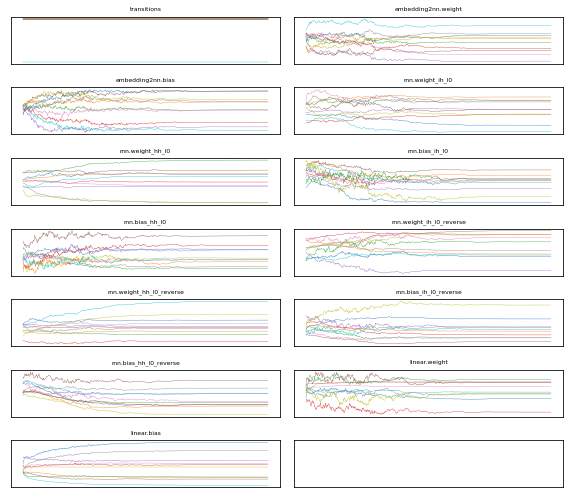

In [13]:
# 8. plot weight traces (optional)
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('resources/taggers/example-ner/weights.txt')

## Using Trained Model for Prediction  <a class="anchor" id="ner-predict"></a>

In [14]:
import flair, torch
device = 'cuda:2'
flair.device = torch.device(device)
from flair.data import Sentence
from flair.models import SequenceTagger

In [15]:
# load the model you trained
print('Loading model...')
model = SequenceTagger.load('resources/taggers/example-ner/best-model.pt')
print('done.')

Loading model...
2020-04-04 13:06:22,953 loading file resources/taggers/example-ner/best-model.pt
done.


In [16]:
# create example sentence
sentence = Sentence('Москва - город в России')

# predict tags and print
model.predict(sentence)

print(sentence.to_tagged_string())
# Expected output: `Москва <S-Geo> - город в России <S-Geo>`

Москва <S-Geo> - город в России <S-Geo>


In [17]:
from collections import OrderedDict
from tqdm import tqdm

def flair_parse(sents):

    sents = [' '.join(sent) for sent in sents]
    
    for idx, sent in enumerate(tqdm(sents)):
        sent = Sentence(sent)
        model.predict(sent)
        sent = sent.to_tagged_string().split()
        last_idx = len(sent) - 1

        res = []
        for idx, token in enumerate(sent, start=1):
            if not token.startswith('<'):
                next_token = sent[idx] if idx <= last_idx else ''
                res.append({
                    'ID': str(idx),
                    'FORM': token,
                    'LEMMA': None,
                    'UPOS': None,
                    'XPOS': None,
                    'FEATS': OrderedDict(),
                    'HEAD': None,
                    'DEPREL': None,
                    'DEPS': None,
                    'MISC': OrderedDict(
                        [('NE', next_token[3:-1])] if next_token.startswith('<') else []
                    )
                })

        yield res

## Prediction and Saving Results to CONLL-U  <a class="anchor" id="ner-save"></a>

In [18]:
from corpuscula import Conllu

Conllu.save(flair_parse(parsed_corpus_test), 'flair_syntagrus.conllu',
            fix=True, log_file=None)

100%|██████████| 3798/3798 [00:07<00:00, 503.58it/s]
